In [1]:
import pandas as pd
import h3.api.numpy_int as h3

import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from shapely.geometry import Polygon, Point
import seaborn as sns
import re

import stc_unicef_cpi.data.get_satellite_data as ge
import stc_unicef_cpi.data.make_dataset as md
import stc_unicef_cpi.utils.general as g
import stc_unicef_cpi.utils.constants as c

import stc_unicef_cpi.utils.geospatial as geo
import stc_unicef_cpi.utils.clean_text as ct
import stc_unicef_cpi.utils.model_utils as mu

/home/marina/miniconda3/envs/dssg_prova_2/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/src/stc_unicef_cpi/features/autoencoder_features.py:21: UserWarning: Necessary modules for autoencoder features not found - assumed not desired
  warnings.warn(


In [3]:
read_path = '/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data'

In [4]:
raw = pd.read_csv(read_path + '/raw/childpoverty_microdata_gps_21jun22.csv')

In [5]:
hexes_dhs = pd.read_csv(read_path + '/processed/20221102_hexes_dhs.csv', dtype={'hex_code':int})
hexes_dhs.shape

(150212, 166)

In [6]:
pd.set_option("display.max_columns", 200)

In [7]:
def plot_africa(ax=None):
    shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
        )

    # read the shapefile using geopandas
    world = gpd.read_file(shpfilename)

    # select countries in Africa
    africa = world[world['CONTINENT'] == "Africa"]
    if ax==None:
        africa.plot(edgecolor="black", facecolor='#edeaea', lw=0.25) 
    else:
        africa.plot(ax = ax, edgecolor="black", facecolor='#edeaea', lw=0.25) 


In [8]:
def plot_country(country_code, ax=None, color='#edeaea'):
    shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
        )

    # read the shapefile using geopandas
    world = gpd.read_file(shpfilename)

    # select countries in Africa
    country = world[world['ADM0_A3'] == country_code]
    if ax==None:
        country.plot(edgecolor="black", facecolor=color, lw=0.25) 
    else:
        country.plot(ax = ax, edgecolor="black", facecolor=color, lw=0.25) 

In [9]:
def plot_subnational(country_code, ax=None):
    # Set up reader for this file
    shpfilename = shpreader.natural_earth(category='cultural', resolution='10m', name='admin_1_states_provinces')
    world_adm1 = gpd.read_file(shpfilename)

    # select countries in Africa
    country = world_adm1[world_adm1['adm0_a3'] == country_code]
    if ax==None:
        country.plot(edgecolor="black", facecolor='#edeaea', lw=0.25) 
    else:
        country.plot(ax=ax, edgecolor="black", facecolor='#edeaea', lw=0.25) 


# Add hexcode to raw

In [85]:
raw.dropna(subset=['LATNUM'], inplace=True)
raw.shape

(2369393, 26)

In [86]:
raw = geo.get_hex_code(raw, 'LATNUM', 'LONGNUM', 7)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [87]:
raw['dep_2_or_more_sev'] = raw['sumpoor_sev']>1
raw['dep_3_or_more_sev'] = raw['sumpoor_sev']>2
raw['dep_4_or_more_sev'] = raw['sumpoor_sev']>3

In [88]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev',
       'dep_2_or_more_sev', 'dep_3_or_more_sev', 'dep_4_or_more_sev']

In [89]:
dimensions_count = [re.sub('sev', 'count', dep) for dep in dimensions]
dic_rename = dict(zip(dimensions, dimensions_count))

In [90]:
grouped_count = raw.groupby('hex_code', as_index=False)[dimensions].agg('count')
grouped_count.rename(columns= dic_rename, inplace=True)


In [93]:
hexes_dhs = pd.merge(hexes_dhs, grouped_count, how='left', on='hex_code')
hexes_dhs.shape

(150271, 166)

In [94]:
hexes_dhs.head(2)

,hex_code,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,geometry,length_km,area_km2,road_density,avg_d_kbps,avg_u_kbps,GSM,LTE,UMTS,avg_signal,elevation,evapotrans,ndvi,ndwi,avg_rad,cf_cvg,pdsi,Optical_Depth_047,Optical_Depth_055,precimean,precistd,slope,2019gdp,africa,ec2019,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,child_pop,rwi,rwi_error,survey,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,latnum,longnum,dep_2_or_more_sev,dep_3_or_more_sev,dep_4_or_more_sev,hex_centroid,year_mean_neigh,round_mean_neigh,cluster_mean_neigh,hhid_mean_neigh,indid_mean_neigh,location_mean_neigh,sex_mean_neigh,wealth_mean_neigh,wealthscore_mean_neigh,age_mean_neigh,hhweight_mean_neigh,sumpoor_prev_neigh,sumpoor_count_neigh,housing_prev_neigh,housing_count_neigh,water_prev_neigh,water_count_neigh,sanitation_prev_neigh,sanitation_count_neigh,nutrition_prev_neigh,nutrition_count_neigh,health_prev_neigh,health_count_neigh,education_prev_neigh,education_count_neigh,deprived_sev_mean_neigh,deprived_sev_count_neigh,region_mean_neigh,region2_mean_neigh,latnum_mean_neigh,longnum_mean_neigh,2_or_more_prev_neigh,2_or_more_count_neigh,3_or_more_prev_neigh,3_or_more_count_neigh,4_or_more_prev_neigh,4_or_more_count_neigh,precipiacc,cnfd,accessibility,accessibility_walking_only,population,M_0,M_1,M_5,M_10,M_15,M_30,M_20,M_25,M_35,M_40,M_45,M_50,M_55,M_60,M_70,M_75,M_65,M_80,F_0,F_1,F_5,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_60,F_50,F_55,F_65,F_70,F_75,F_80,country_code,country,NR,CDMA,hex_code_str,water_surface,no_built,build_2000_2014,build_1990_2000,build_1975_1990,build_prior_1975,largest,sumpoor_count,dep_housing_count,dep_water_count,dep_sanitation_count,dep_nutrition_count,dep_health_count,dep_education_count,deprived_count,dep_2_or_more_count,dep_3_or_more_count,dep_4_or_more_count
0,610276395859312639,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.732904100477812, -4.623059167412168), (12...",10.689607,5.311200,2.012654,NaN,NaN,0.0,0.0,0.0,NaN,211.45454,727.532504,0.343543,0.282376,0.157719,2.329546,1382.3182,382.359320,274.391760,0.127455,0.148234,5.437882,NaN,0.001981,NaN,NaN,NaN,NaN,6.167462,-0.336534,0.228155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4.615699589011692, 12.722683696731998)",2015.0,71.0,77.000000,13.196721,4.360656,2.0,1.557377,2.934426,25245.852459,6.770492,0.392661,1.327869,61.0,0.114754,61.0,0.770492,61.0,0.409836,61.0,0.000000,12.0,0.000000,15.0,0.054054,37.0,0.770492,61.0,1.0,NaN,-4.653519,12.731428,0.475410,61.0,0.081967,61.0,0.0,61.0,2987.668259,0.000000,11.793229,71.0,12.868066,0.188045,0.789752,0.823278,0.797216,0.688460,0.413089,0.560355,0.533317,0.298992,0.242842,0.194163,0.193840,0.205593,0.102158,0.040404,0.022762,0.092256,0.013325,0.188357,0.791061,0.881214,0.853318,0.736909,0.662420,0.630457,0.488330,0.353451,0.287074,0.178695,0.094020,0.178397,0.189214,0.084906,0.037185,0.020948,0.012264,AGO,Angola,NaN,NaN,87823260dffffff,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,610276262933430271,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.219237535243943, -5.6090981921783225), (1...",37.112027,5.311707,6.986836,15717.0,6479.0,1.0,0.0,0.0,0.0,68.95238,646.698793,0.215418,0.079168,5.743694,4.614418,1458.4762,364.300402,260.929612,0.127418,0.126591,5.127139,NaN,0.043447,NaN,435346.72,346996.25,4316442.5,297.571244,0.716460,0.509262,229.0,2015.0,71.0,313.541485,14.218341,5.100437,1.0,1.480349,3.733624,88895.668122,7.161572,0.614931,0.484716,0.135371,0.063636,0.148472,0.0,0.035714,0.201342,0.388646,1.0,NaN,-5.599547,12.20373,0.09607,0.0,0.0,"(-5.601659871826836, 12.20904389095013)",2015.0,71.0,292.231527,14.064039,5.009852,1.0,1.507389,3.815271,95529.032020,7.600985,0.568976,0.426108,406.0,0.160099,406.0,0.035264,397.0,0

In [96]:
hexes_dhs.to_csv(read_path + '/processed/20221030_hexes_dhs.csv', index=False)

# Years of DHS surveys

In [12]:
countries_ssf = ['Angola', 
            'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
            'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, The Democratic Republic of the', 'Congo', "Côte d'Ivoire",
            'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
            'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
            'Kenya', 
            'Lesotho', 'Liberia', 
            'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique',
            'Namibia', 'Niger', 'Nigeria',
            'Rwanda', 
            'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'South Sudan', 
            'Tanzania, United Republic of', 'Togo', 
            'Uganda',
            'Zambia', 'Zimbabwe']

In [16]:
countries_dhs = pd.DataFrame(columns=['country', 'country_code', 'dhs_children', 'dhs_year', 'mics_children', 'mics_year'])

for country in countries_ssf:
    country_code = ct.get_alpha3_code(country)

    if country_code in list(raw['countrycode']):
        subset = raw[raw['countrycode']==country_code]
        # print('check if there are nan values')
        # print(subset['deprived_sev'].value_counts())
        dhs = subset[subset.survey=='DHS']
        if dhs.shape[0]!= 0:
            year_dhs = dhs.year.mean()
            num_dhs = dhs.shape[0]
        else:
            year_dhs, num_dhs = 0, 0

        mics = subset[subset.survey=='MICS']
        if mics.shape[0]!= 0:
            year_mics = mics.year.mean()
            num_mics = mics.shape[0]
        else:
            year_mics, num_mics = 0, 0

        countries_dhs = countries_dhs.append({'country':country,  'country_code':country_code, 'dhs_children': num_dhs, 'dhs_year':year_dhs, 
                    'mics_children':  num_mics,   'mics_year': year_mics}, ignore_index=True)
    
        

In [19]:
country_mics = countries_dhs[countries_dhs['mics_children']!= 0].copy()
countries_dhs = countries_dhs[countries_dhs['dhs_children']!= 0].copy()

In [23]:
country_mics

,country,country_code,dhs_children,dhs_year,mics_children,mics_year
5,Central African Republic,CAF,0,0.0,25430,2019.0
6,Chad,TCD,0,0.0,67164,2019.0
8,"Congo, The Democratic Republic of the",COD,53868,2013.0,57566,2018.0
9,Congo,COG,0,0.0,26691,2015.0
10,Côte d'Ivoire,CIV,0,0.0,28377,2016.0
11,Eswatini,SWZ,0,0.0,10131,2014.0
13,Gambia,GMB,0,0.0,32786,2018.0
14,Ghana,GHA,0,0.0,30663,2017.0
16,Guinea-Bissau,GNB,0,0.0,24206,2019.0
18,Lesotho,LSO,16898,2014.0,13989,2018.0


In [14]:
# countries_dhs = pd.read_csv('/mnt/c/Users/vicin/Desktop/DSSG/Data/Tables tesi/countries_with_output.csv', dtype = {'DHS year':int})
# countries_dhs = countries_dhs.rename(columns = {'Country':'country', 'Code':'country_code', 'DHS year':'dhs_year', 'Number of children with DHS':'dhs_children'})
countries_dhs.head(3)

,country,country_code,dhs_children,dhs_year,num hex with output,num hex with neigh,tot
0,Angola,AGO,42167,2015,519,6050,220183
1,Benin,BEN,40064,2017,475,5065,28345
2,Burkina Faso,BFA,44464,2010,501,7154,67132


In [38]:
# ctry_code = ct.get_alpha3_code('')
shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

# select countries in Africa
africa = world[world['CONTINENT'] == "Africa"]

In [4]:
africa.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
13,Admin-0 country,0,2,Ethiopia,ETH,0,2,Sovereign country,1,Ethiopia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((34.07070 9.45459, 34.06689 9.53118, ..."
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."


In [5]:
to_plot = africa.merge(countries_dhs, how='left', right_on = 'country_code', left_on = 'ADM0_ISO')
to_plot = to_plot[to_plot.country_code.isna()==False].copy()
to_plot['dhs_year'] = to_plot['dhs_year'].apply(lambda x: int(x))
print(to_plot.shape)

(25, 176)


In [6]:
sorted(to_plot.dhs_year.unique())

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Countries with DHS surveys and the latest year it was done


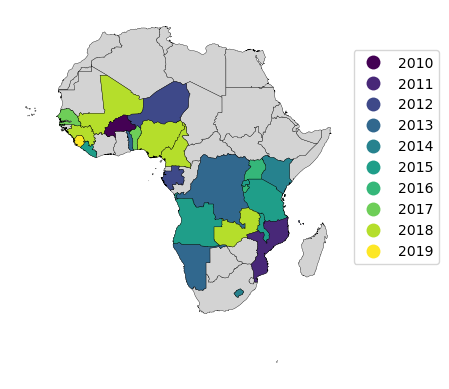

In [7]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

print('Countries with DHS surveys and the latest year it was done')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_year',  lw=0.25, 
            categorical=True, legend=True,
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.6),
                         'fmt': "{:.0f}"}) 



Children surveys per country


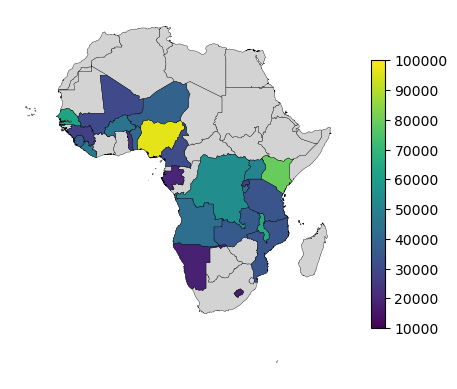

In [8]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

vmin, vmax = 10000, 100000

print('Children surveys per country')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_children',  lw=0.25, vmin = vmin, vmax = vmax, 
            # legend=True,
            # legend_kwds={"shrink":.9},
            )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)


# Correlation between dimensions

In [4]:
hexes_dhs_no_neigh = hexes_dhs[hexes_dhs['deprived_sev'].isna()==False].copy()
hexes_dhs_no_neigh.shape

(12460, 166)

In [5]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev', 
       'dep_2_or_more_sev', 'dep_3_or_more_sev',
       'dep_4_or_more_sev']
labels = ['depth', 'housing', 'water', 'sanitation', 'nutrition', 'health', 'education', 'prevalence', '2 or more', '3 or more', '4 or more']

In [6]:
corr_no_neigh = hexes_dhs_no_neigh[dimensions].corr()

In [9]:
# fig, ax = plt.subplots(dpi=300)

# sns.color_palette("gray_r", as_cmap=True)

# sns.heatmap(corr_no_neigh,
#             square=True,
#             cmap = sns.color_palette("gray_r", as_cmap=True),
#             xticklabels=labels, yticklabels=labels,
#             linewidth=.5)

<AxesSubplot:>

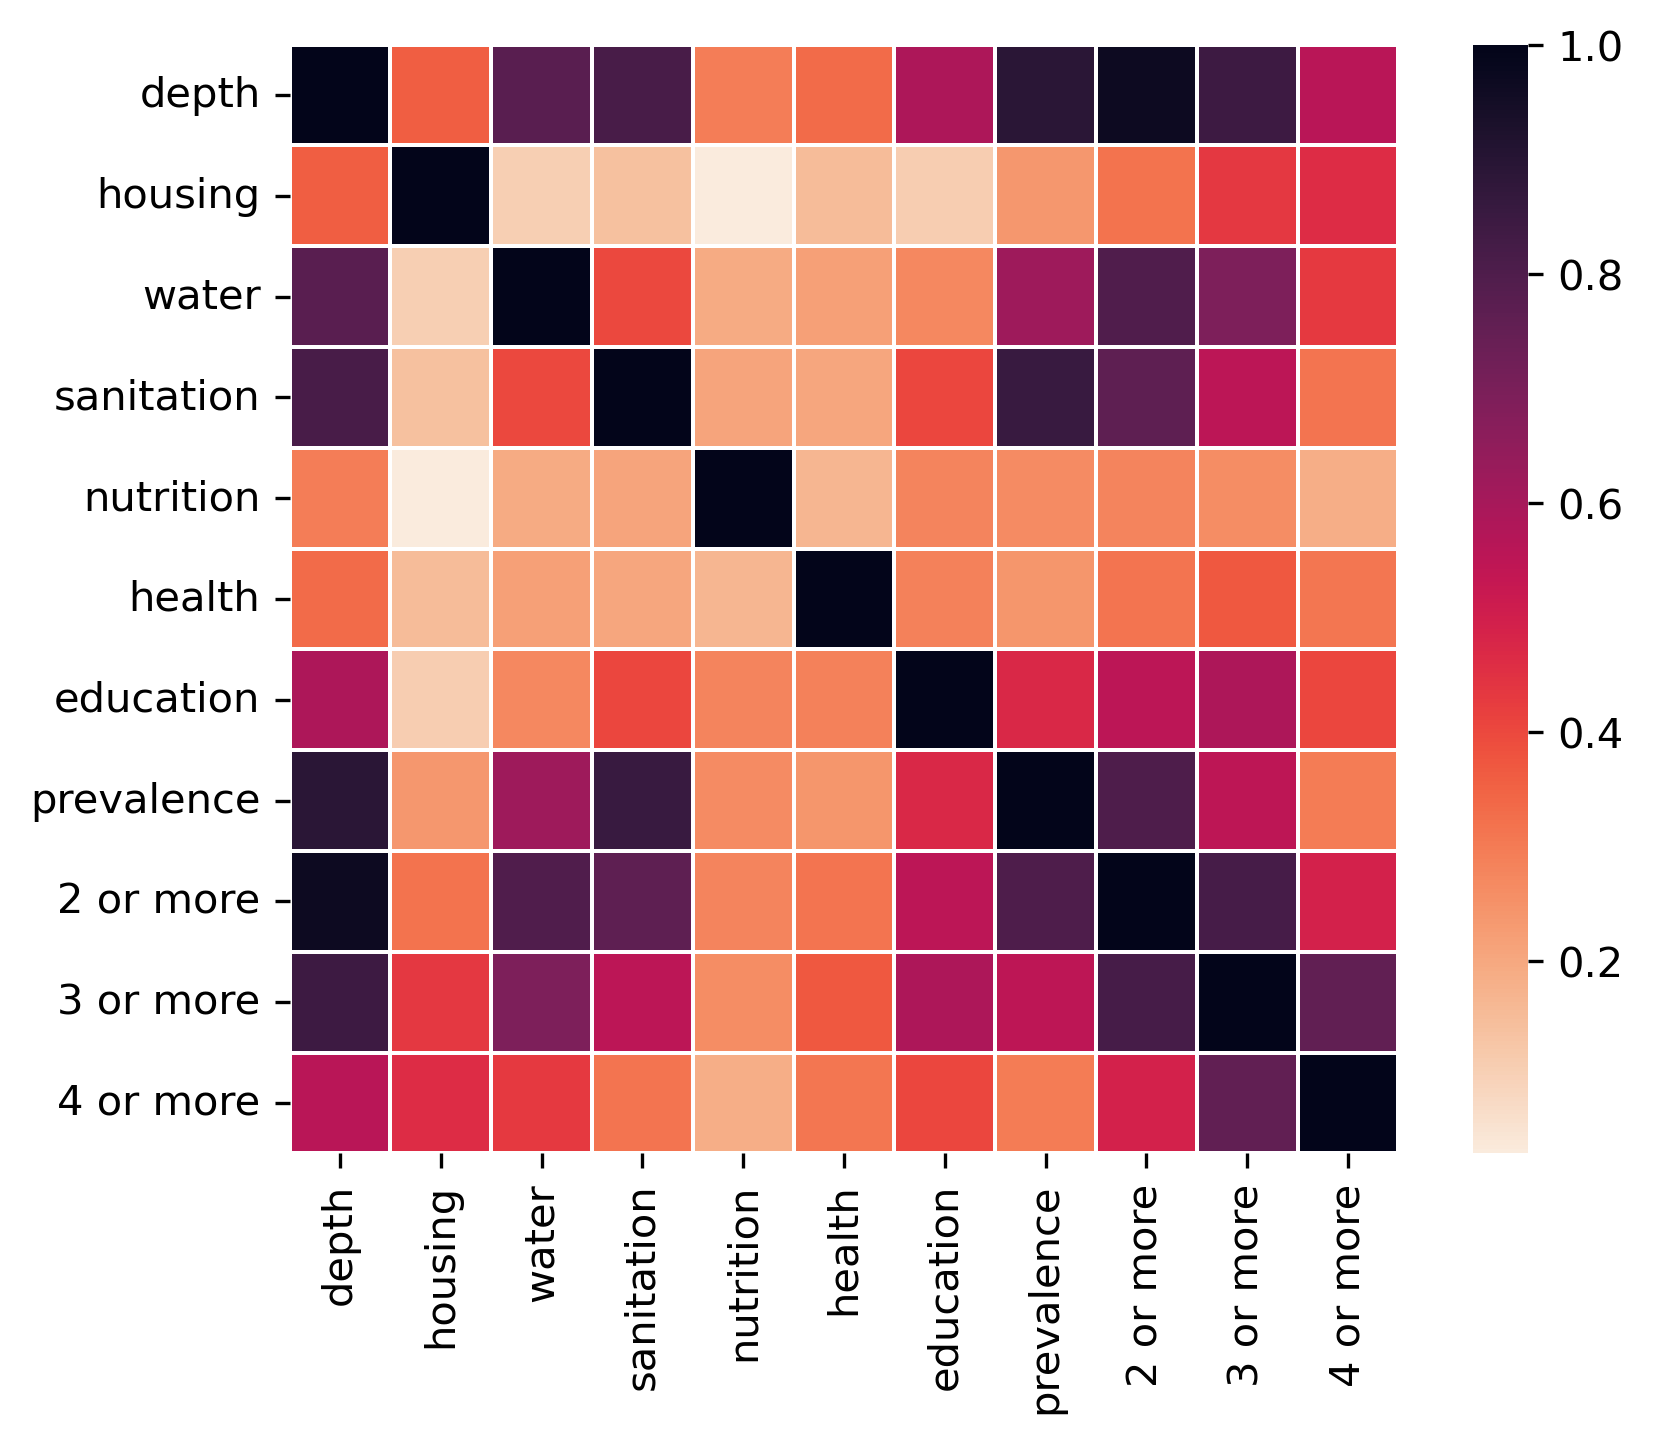

In [12]:
fig, ax = plt.subplots(dpi=300)

sns.color_palette("rocket_r", as_cmap=True)

sns.heatmap(corr_no_neigh,
            square=True,
            cmap = sns.color_palette("rocket_r", as_cmap=True),
            xticklabels=labels, yticklabels=labels,
            linewidth=.5)

# Correlation btw input and output

In [117]:
corr_mat = hexes_dhs.corr()

In [131]:
dimensions = ['sumpoor_sev', 'dep_housing_sev',
 'dep_water_sev', 'dep_sanitation_sev', 'dep_nutrition_sev',
 'dep_health_sev', 'dep_education_sev', 'deprived_sev',
 'dep_2_or_more_sev'] #,
#  'dep_3_or_more_sev', 'dep_4_or_more_sev']

In [121]:
# to_keep = []
# thr = 0.5
# for col in corr_mat.columns:
#     values = corr_mat[col]
#     values = values.drop(col)
#     mi, ma = values.min(), values.max()
#     if (mi < - thr) | (ma > thr):
#         # print(f'{col} - min: {corr_mat[col].min()}, max: {corr_mat[col].max()}')
#         to_keep.append(col)
# len(to_keep)

145

In [28]:
# sns.heatmap(corr_mat[to_keep])

In [137]:
input = ['win_population_commuting', 
       'roads_commuting', #'win_roads_km_commuting',
       'area_commuting', 'n_conflicts', 'length_km', 'area_km2',
       'road_density', 'avg_d_kbps', 'avg_u_kbps', 'GSM', 'LTE', 'UMTS',
       'avg_signal', 'elevation', 'evapotrans', 'ndvi', 'ndwi', 'avg_rad',
       'cf_cvg', 'pdsi', 'Optical_Depth_047', 'Optical_Depth_055', 'precimean',
       'precistd', 'slope', '2019gdp', 'africa', 'ec2019', 'GDP_PPP_1990',
       'GDP_PPP_2000', 'GDP_PPP_2015', 'child_pop', 'rwi', 'rwi_error',
       'precipiacc',
       'cnfd', 'accessibility', 
       'accessibility_walk', #'accessibility_walking_only',
       'population',
       'M_0', 'M_1', 'M_5', 'M_10', 'M_15', 'M_30', 'M_20', 'M_25', 'M_35',
       'M_40', 'M_45', 'M_50', 'M_55', 'M_60', 'M_70', 'M_75', 'M_65', 'M_80',
       'F_0', 'F_1', 'F_5', 'F_10', 'F_15', 'F_20', 'F_25', 'F_30', 'F_35',
       'F_40', 'F_45', 'F_60', 'F_50', 'F_55', 'F_65', 'F_70', 'F_75', 'F_80',
       'NR', 'CDMA', 'water_surface', 'no_built', 'build_2000_2014',
       'build_1990_2000', 'build_1975_1990', 'build_prior_1975',
       ]

In [120]:
len(input)

83

In [138]:
corr_mat.rename({'win_roads_km_commuting':'roads_commuting',
                'accessibility_walking_only':'accessibility_walk'
                }, axis=0, inplace=True)

In [139]:
to_keep = []
thr = 0.30
for col in input:
    values = corr_mat.loc[str(col)][dimensions]
    mi, ma = values.min(), values.max()
    if (mi < - thr) | (ma > thr):
        print(f'{col} - min: {mi}, max: {ma}')
        to_keep.append(col)
len(to_keep)

roads_commuting - min: 0.0485330888115661, max: 0.3274590826991941
area_commuting - min: 0.10488425070014414, max: 0.34004002322067933
length_km - min: -0.5024647109222627, max: -0.03637405368403825
road_density - min: -0.5039630680639446, max: -0.032416988009298826
ndwi - min: -0.35378834711482443, max: 0.09708040663228067
precistd - min: -0.3105878269647777, max: -0.009242781274532253
africa - min: -0.41676390372804917, max: 0.004837863388626502
child_pop - min: -0.30866810051862653, max: 0.02579027246559274
rwi - min: -0.5601860809404191, max: -0.010869801566178589
rwi_error - min: -0.41535632445387705, max: -0.015011768729237346
precipiacc - min: -0.30649242960121026, max: 0.060852513303369084
cnfd - min: -0.4260751177484812, max: 0.015612711831621955
accessibility - min: 0.10120446924912656, max: 0.3353026383833141
accessibility_walk - min: 0.09941590516450965, max: 0.31329872097187
population - min: -0.3118546597327109, max: 0.03147902953299293
M_0 - min: -0.3058356845921889, max

40

In [140]:
labels = ['depth', 'housing', 'water', 'sanitation', 'nutrition', 'health', 'education', 'prevalence', '2 or more']

<AxesSubplot:>

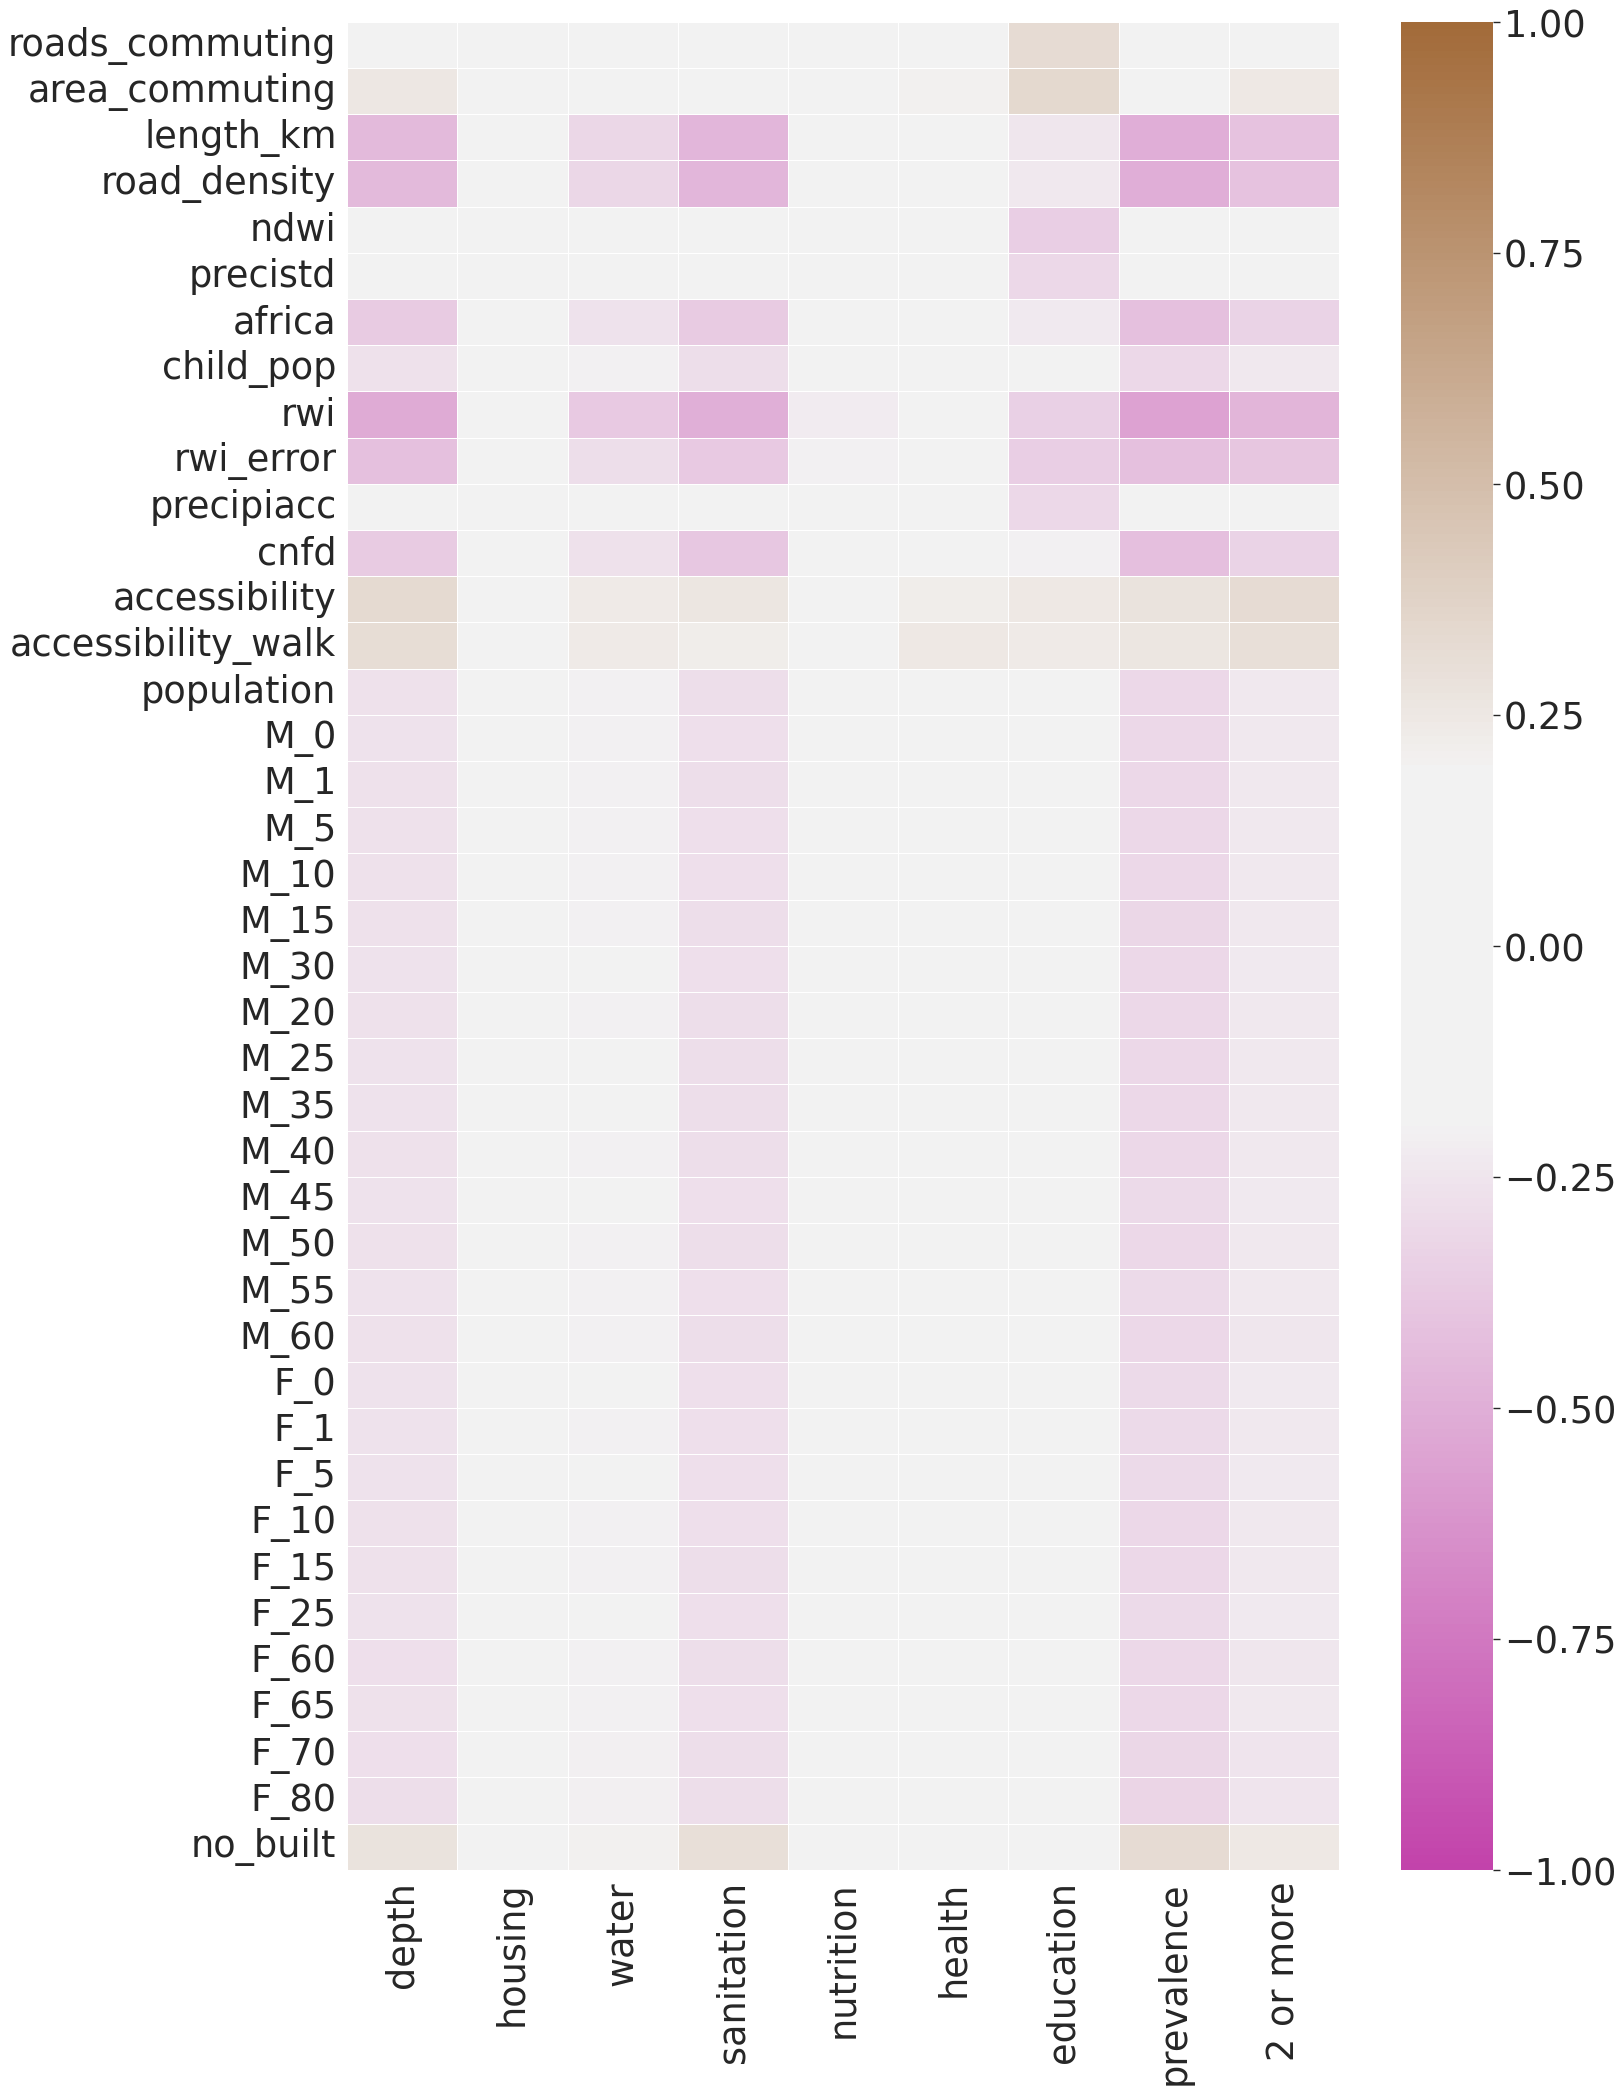

In [141]:
plt.figure(figsize=(20, 30), dpi=80)

cmap = sns.diverging_palette(320, 40, sep=50, as_cmap=True)

sns.heatmap(corr_mat.loc[to_keep][dimensions], 
            cmap = cmap, 
            vmin=-1, vmax=1, 
            xticklabels=labels,
            linewidths=0.5)



<AxesSubplot:>

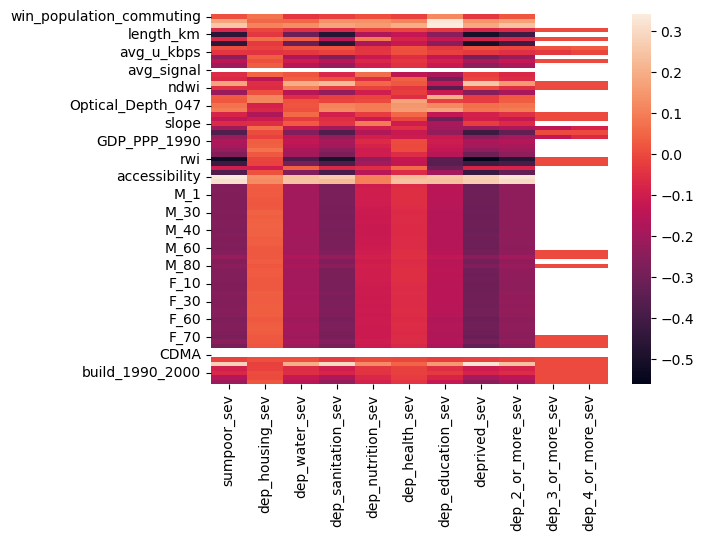

In [142]:
sns.heatmap(corr_mat.loc[input][dimensions])

In [159]:
hexes_dhs.columns[100:]

Index(['4_or_more_prev_neigh', '4_or_more_count_neigh', 'precipiacc', 'cnfd',
       'accessibility', 'accessibility_walking_only', 'population', 'M_0',
       'M_1', 'M_5', 'M_10', 'M_15', 'M_30', 'M_20', 'M_25', 'M_35', 'M_40',
       'M_45', 'M_50', 'M_55', 'M_60', 'M_70', 'M_75', 'M_65', 'M_80', 'F_0',
       'F_1', 'F_5', 'F_10', 'F_15', 'F_20', 'F_25', 'F_30', 'F_35', 'F_40',
       'F_45', 'F_60', 'F_50', 'F_55', 'F_65', 'F_70', 'F_75', 'F_80',
       'country_code', 'country', 'NR', 'CDMA', 'hex_code_str',
       'water_surface', 'no_built', 'build_2000_2014', 'build_1990_2000',
       'build_1975_1990', 'build_prior_1975', 'largest', 'sumpoor_count',
       'dep_housing_count', 'dep_water_count', 'dep_sanitation_count',
       'dep_nutrition_count', 'dep_health_count', 'dep_education_count',
       'deprived_count', 'dep_2_or_more_count', 'dep_3_or_more_count',
       'dep_4_or_more_count'],
      dtype='object')

# Missing values of dimensions

## no neigh

In [31]:
dimensions = ['sumpoor_sev',
 'dep_housing_sev',
 'dep_water_sev',
 'dep_sanitation_sev',
 'dep_nutrition_sev',
 'dep_health_sev',
 'dep_education_sev',
 'deprived_sev',
 ]

In [32]:
d = {}
for col in dimensions:
    col_count = re.sub('_sev', '_count', col)
    num_no_na = hexes_dhs_no_neigh[(hexes_dhs_no_neigh[col].isna()==False) & (hexes_dhs_no_neigh[col_count]>30)].shape[0]
    d[col] = num_no_na

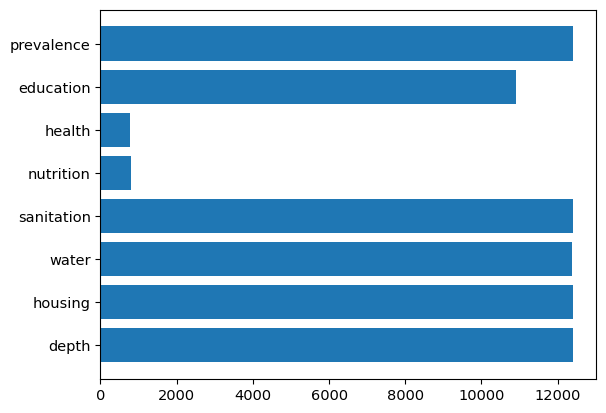

In [35]:
fig, ax = plt.subplots()# dpi=300)

plt.barh(list(d.keys()), list(d.values()))
_ = ax.set_yticklabels(labels, fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=10.5)


## neigh

In [19]:
dimensions_neigh = ['sumpoor_prev_neigh',
       'housing_prev_neigh','water_prev_neigh',
       'sanitation_prev_neigh',
       'nutrition_prev_neigh', 'health_prev_neigh',
       'education_prev_neigh',
       'deprived_sev_mean_neigh']

In [20]:
d_neigh = {}
for col in dimensions_neigh:
    col_count = re.sub('(prev|mean)', 'count', col)
    num_no_na = hexes_dhs[(hexes_dhs[col].isna()==False) & (hexes_dhs[col_count]>30)].shape[0]
    d_neigh[col] = num_no_na

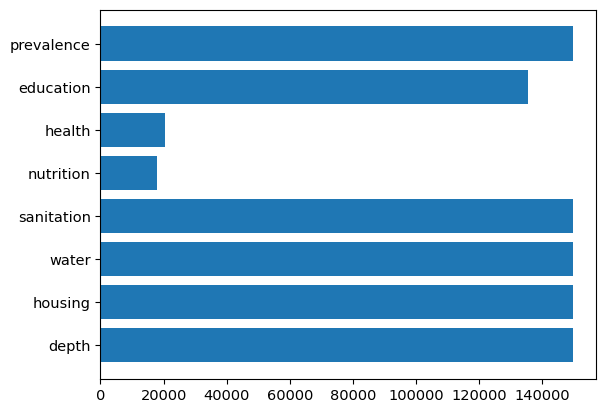

In [23]:
fig, ax = plt.subplots()# dpi=300)

plt.barh(list(d_neigh.keys()), list(d_neigh.values()))
_ = ax.set_yticklabels(labels, fontsize = 13)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10.5)
ax.tick_params(axis='both', which='minor', labelsize=8)

# Distribution of output

[Text(0.5, 0, 'Education')]

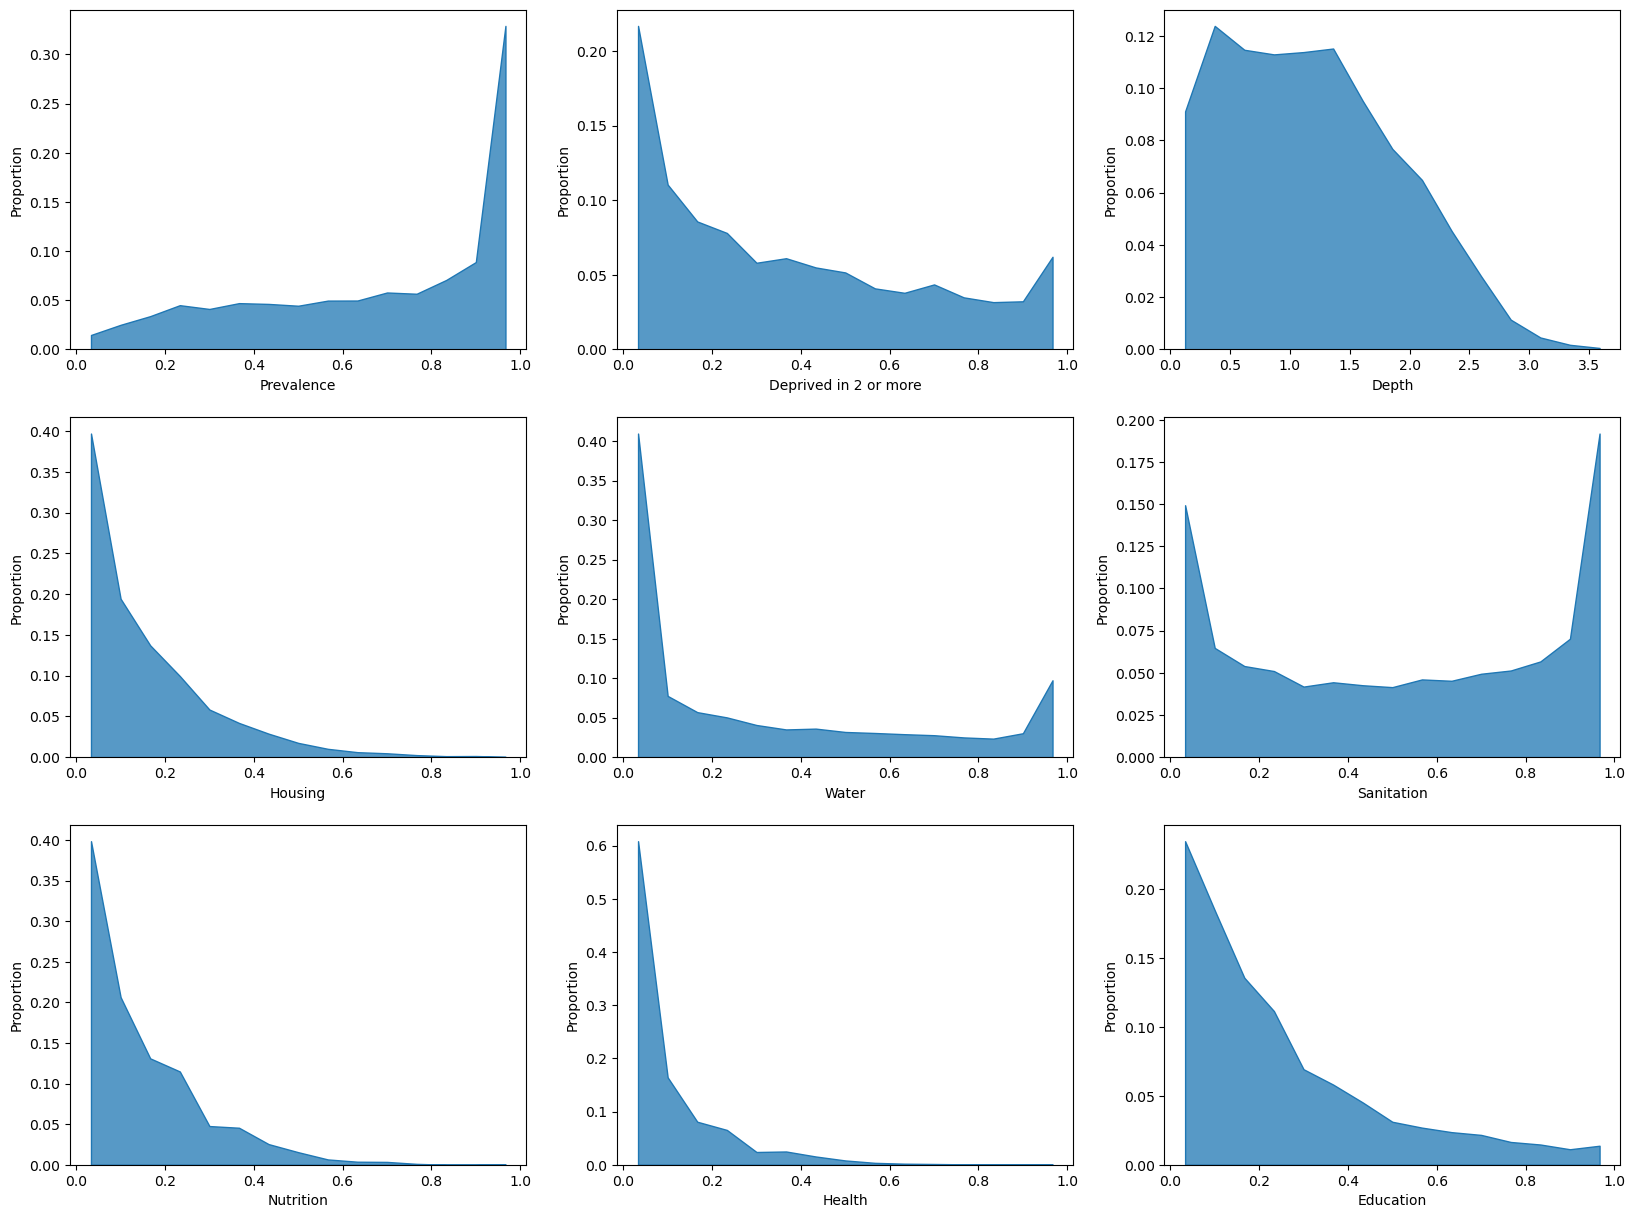

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

stat = 'proportion'
bins = 15
elem = 'poly'

fig, axs = plt.subplots(figsize=(20,15), nrows = 3, ncols=3)
ax00 = sns.histplot(hexes_dhs['deprived_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 0]).set(xlabel='Prevalence')

sns.histplot(hexes_dhs['dep_2_or_more_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 1]).set(xlabel='Deprived in 2 or more')
sns.histplot(hexes_dhs['sumpoor_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 2]).set(xlabel='Depth')

sns.histplot(hexes_dhs['dep_housing_sev'], stat=stat, bins = bins, element= elem, ax=axs[1, 0]).set(xlabel='Housing')
sns.histplot(hexes_dhs['dep_water_sev'], stat=stat, bins = bins, element= elem, ax=axs[1, 1]).set(xlabel='Water')
sns.histplot(hexes_dhs['dep_sanitation_sev'], stat=stat, bins = bins, element= elem, ax=axs[1,2]).set(xlabel='Sanitation')

sns.histplot(hexes_dhs['dep_nutrition_sev'], stat=stat, bins = bins, element= elem, ax=axs[2,0]).set(xlabel='Nutrition')
sns.histplot(hexes_dhs['dep_health_sev'], stat=stat, bins = bins, element= elem, ax=axs[2,1]).set(xlabel='Health')
sns.histplot(hexes_dhs['dep_education_sev'], stat=stat, bins = bins, element= elem, ax=axs[2,2]).set(xlabel='Education')

[Text(0.5, 0, 'Education')]

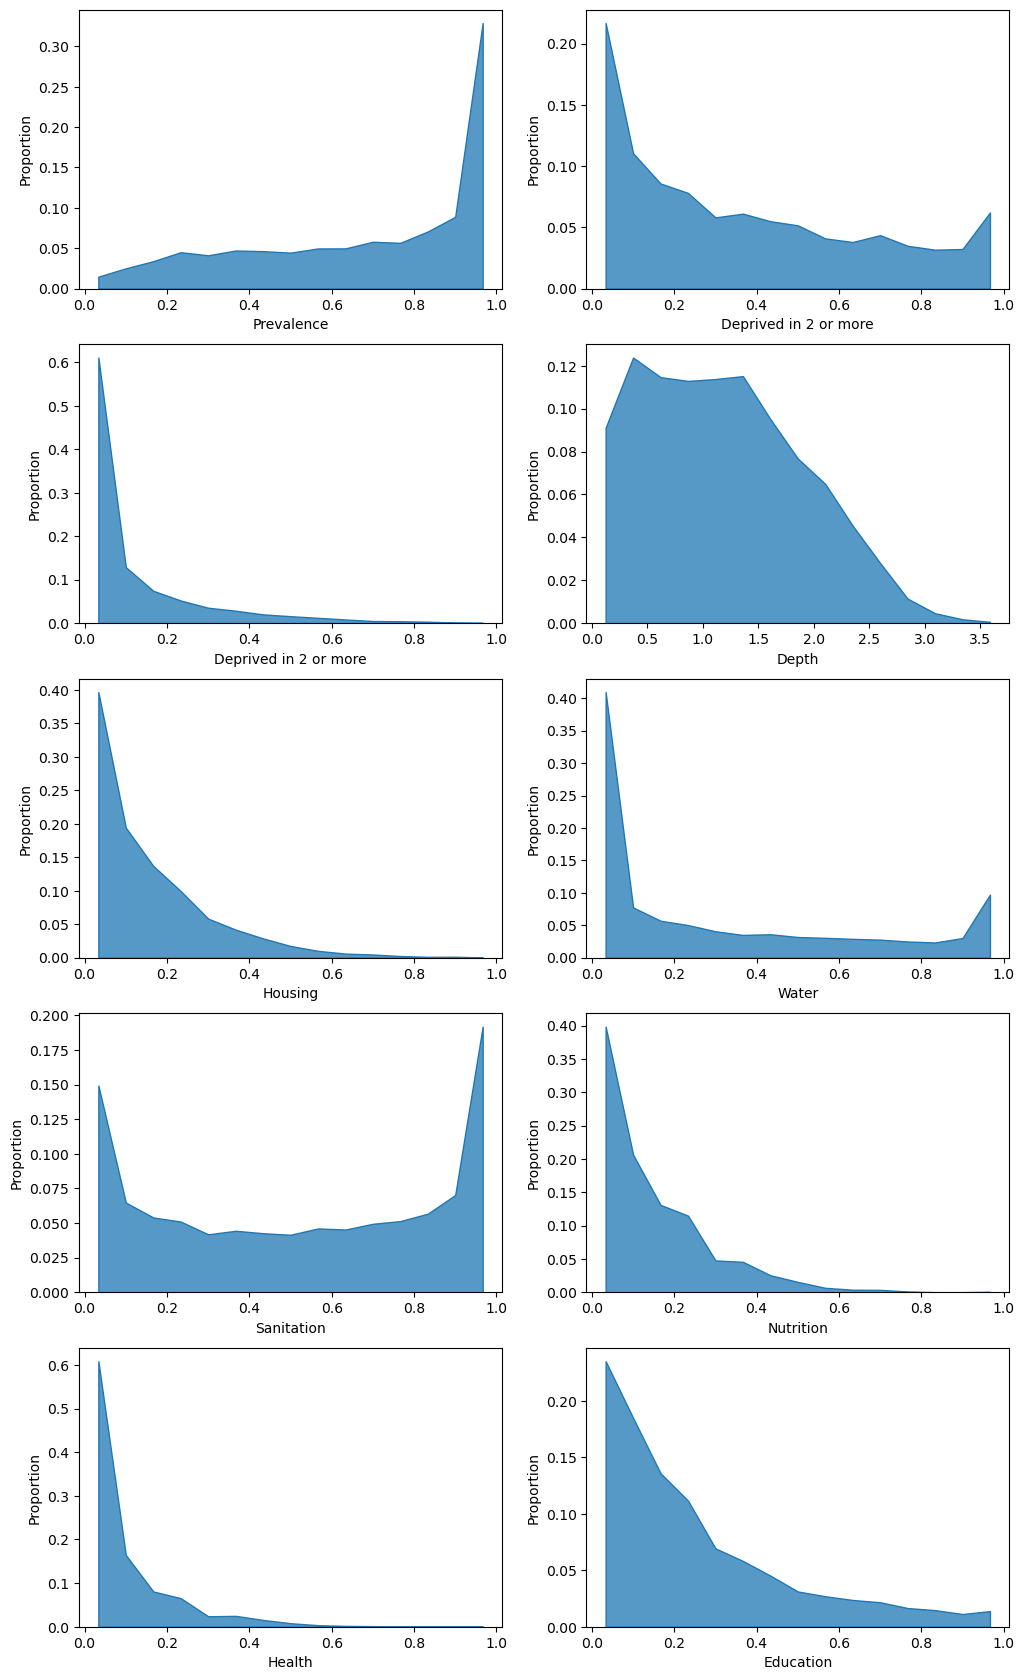

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

stat = 'proportion'
bins = 15
elem = 'poly'

fig, axs = plt.subplots(figsize=(12,21), nrows = 5, ncols=2)
ax00 = sns.histplot(hexes_dhs['deprived_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 0]).set(xlabel='Prevalence')
sns.histplot(hexes_dhs['dep_2_or_more_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 1]).set(xlabel='Deprived in 2 or more')

sns.histplot(hexes_dhs['dep_3_or_more_sev'], stat=stat, bins = bins, element= elem, binrange = (0,1), ax=axs[1, 0]).set(xlabel='Deprived in 2 or more')
sns.histplot(hexes_dhs['sumpoor_sev'], stat=stat, bins = bins, element= elem, ax=axs[1, 1]).set(xlabel='Depth')

sns.histplot(hexes_dhs['dep_housing_sev'], stat=stat, bins = bins, element= elem, ax=axs[2, 0]).set(xlabel='Housing')
sns.histplot(hexes_dhs['dep_water_sev'], stat=stat, bins = bins, element= elem, ax=axs[2, 1]).set(xlabel='Water')

sns.histplot(hexes_dhs['dep_sanitation_sev'], stat=stat, bins = bins, element= elem, ax=axs[3,0]).set(xlabel='Sanitation')
sns.histplot(hexes_dhs['dep_nutrition_sev'], stat=stat, bins = bins, element= elem, ax=axs[3,1]).set(xlabel='Nutrition')

sns.histplot(hexes_dhs['dep_health_sev'], stat=stat, bins = bins, element= elem, ax=axs[4,0]).set(xlabel='Health')
sns.histplot(hexes_dhs['dep_education_sev'], stat=stat, bins = bins, element= elem, ax=axs[4,1]).set(xlabel='Education')

In [61]:
read_path

'/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data'

In [62]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev', 
       'dep_2_or_more_sev', 'dep_3_or_more_sev',
       'dep_4_or_more_sev']

x_labels = ['Depth', 'Housing', 'Water', 'Sanitation', 'Nutrition', 'Health', 'Education', 'Prevalence', 'Deprived in 2 or more', 'Deprived in 3 or more', 'Deprived in 4 or more']

dic_x_lab = dict(zip(dimensions, x_labels))


In [77]:
import math

In [97]:
# dim = 'dep_3_or_more_sev'

# # remove nas
# df = hexes_dhs[hexes_dhs[dim].isna()==False].copy()
# print(df.shape)
# # remove inf
# df = df[[math.isinf(x)==False for x in list(df[dim])]].copy()
# print(df[dim].shape)

(12468, 166)
(12467,)


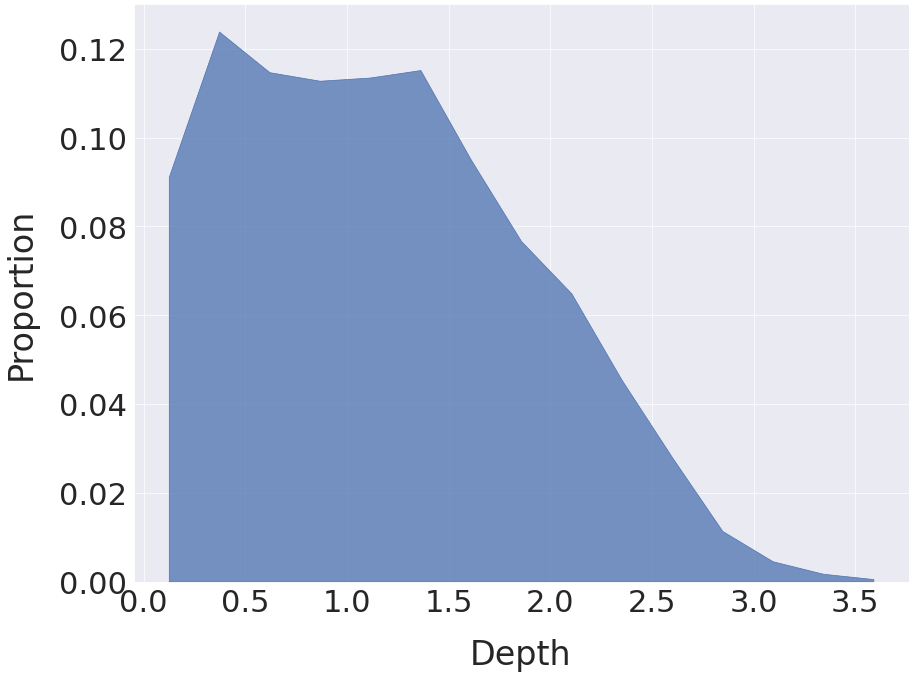

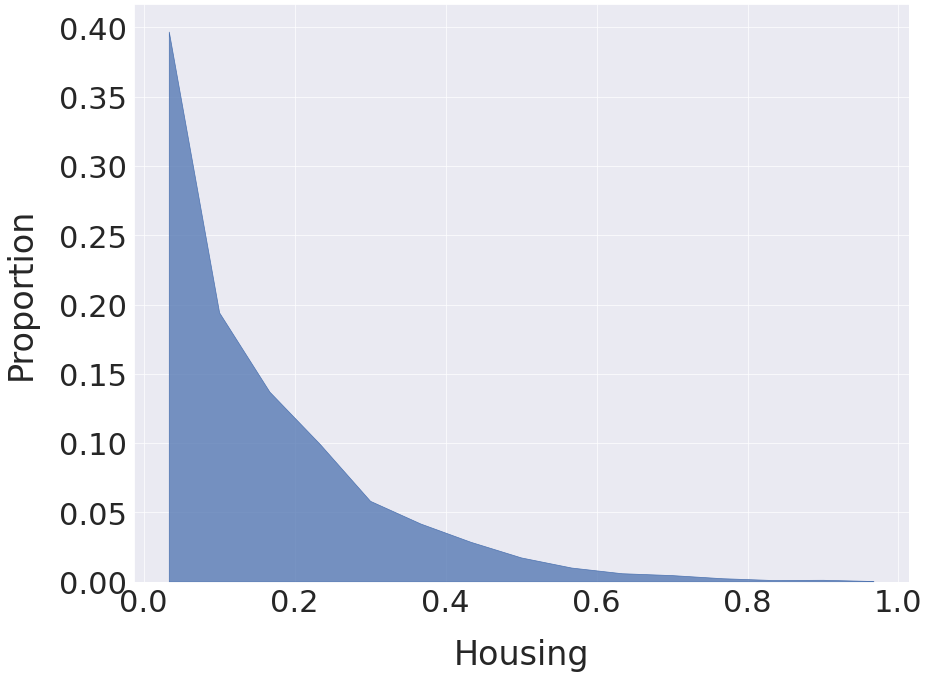

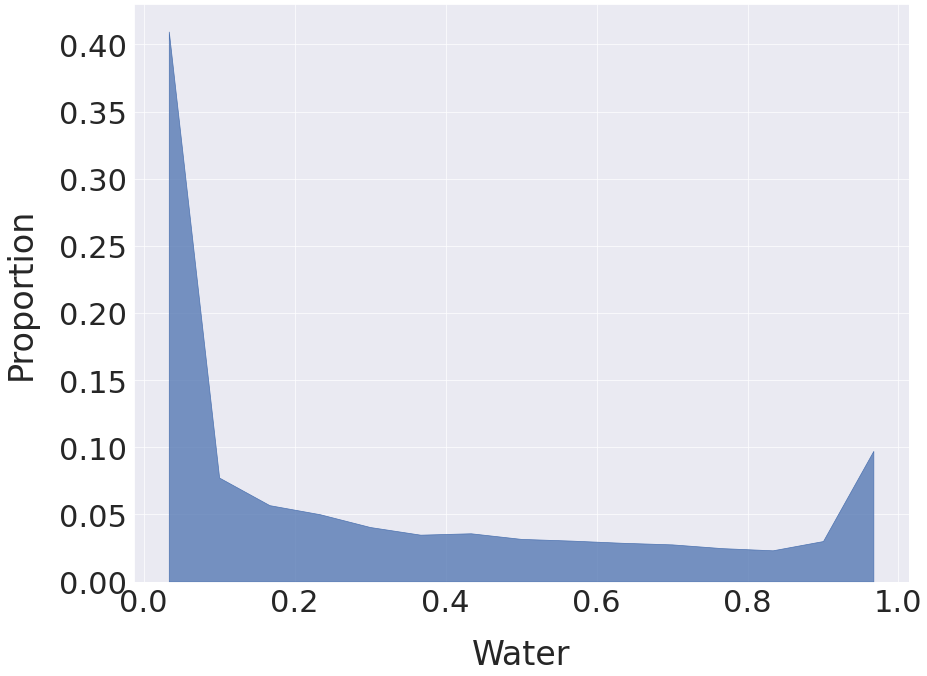

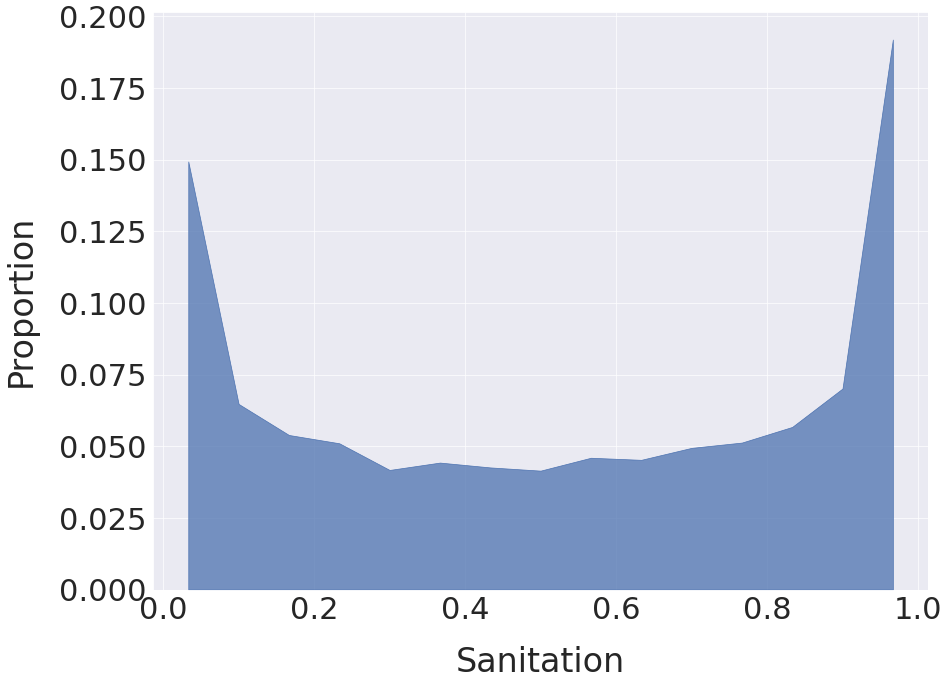

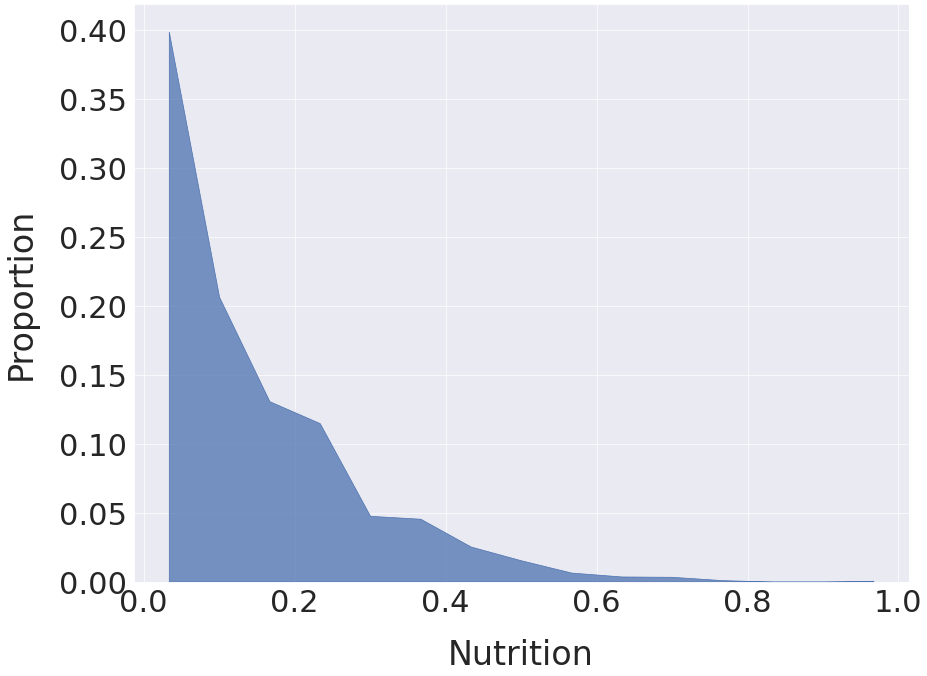

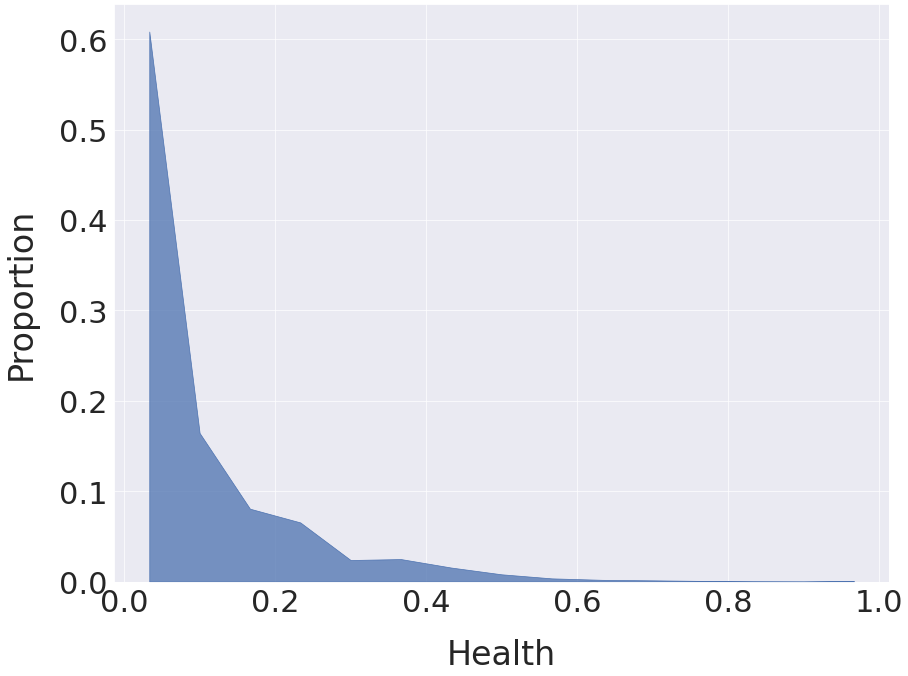

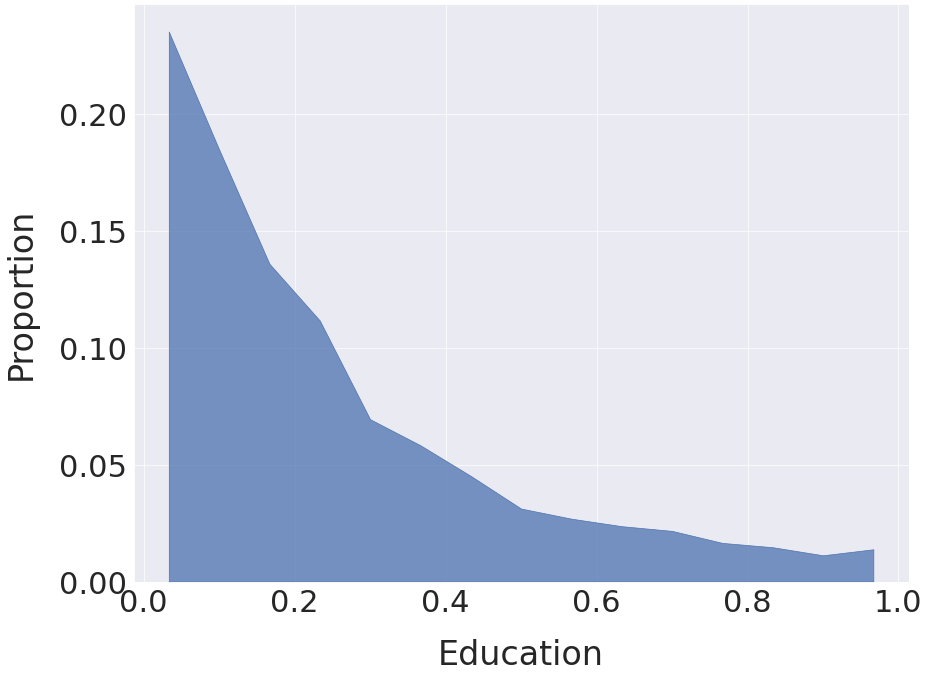

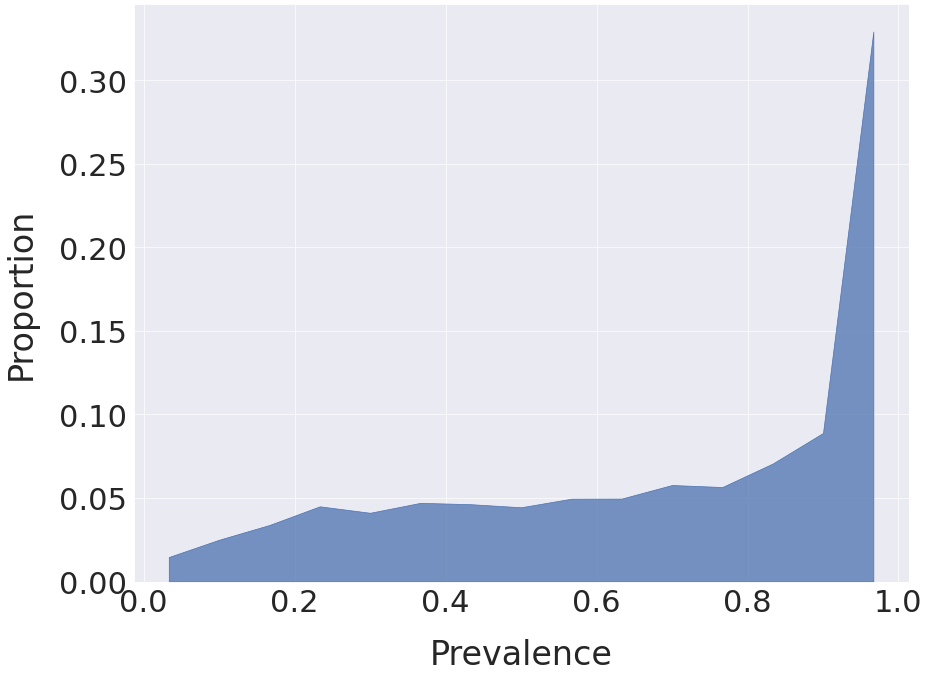

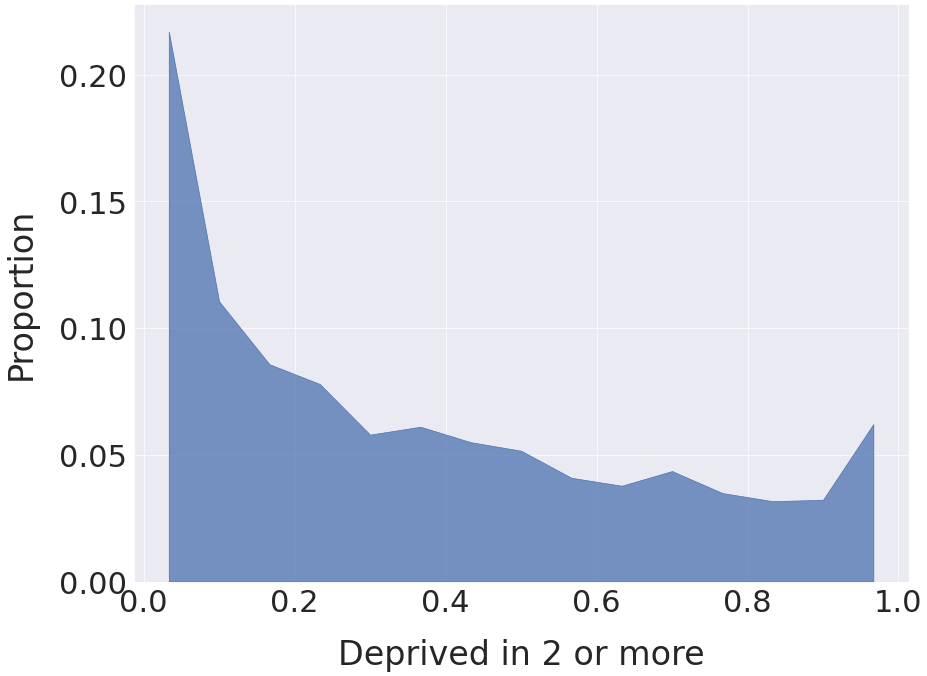

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

stat = 'proportion'
bins = 15
elem = 'poly'

sns.set(font_scale=4)
labelpad = 30

for dim in dimensions:
    fig, ax = plt.subplots(figsize=(20,15), dpi=50)
    
    # remove nas
    df = hexes_dhs[hexes_dhs[dim].isna()==False].copy()
    # remove inf
    df = df[[math.isinf(x)==False for x in list(df[dim])]]
    
    sns.histplot(df[dim], stat=stat, bins = bins, element= elem, ax=ax)

    plt.xlabel(dic_x_lab[dim], labelpad=labelpad)
    plt.ylabel('Proportion', labelpad = labelpad)

    plt.savefig(f'/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data/{dim}.png')


# Hexcode in Nigeria

In [10]:
nga = hexes_dhs[hexes_dhs.country_code == 'NGA'].copy()
nga.shape

(16678, 166)

In [11]:
nga = geo.get_hex_centroid(nga)

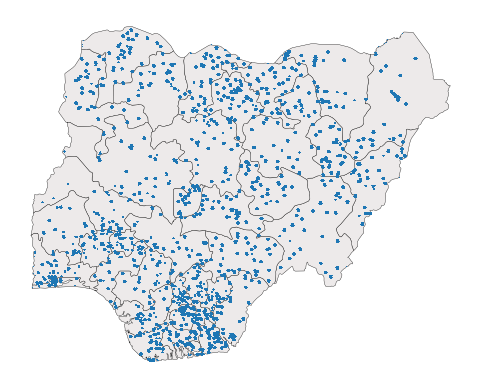

In [15]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

plot_subnational('NGA', ax=ax)
# nga_shp.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

plt.plot(nga['long'], nga['lat'], ',')

plt.show()

# Spatial Cross Validation

In [36]:
country_code = 'NGA'

In [43]:
# select country
df = mu.get_data_country(hexes_dhs, country_code, col='deprived_count')

# drop country code
X, Y = df, df
XY = df
print(X.shape)

X_train, X_test, Y_all_train, Y_all_test = mu.select_eval_split_type(X, Y, eval_split_type='normal', test_size=0.2)
print(X_train.shape)
print(X_test.shape)

kfold, spatial_groups = mu.select_cv_type(cv_type='spatial', nfolds=5, XY=XY, X_train=X_train)

(1284, 166)
(1027, 166)
(257, 166)


In [44]:
X_train['spatial_groups'] = list(spatial_groups)

In [45]:
# get lat and long
X_train = geo.get_hex_centroid(X_train, hex_code="hex_code")
X_test = geo.get_hex_centroid(X_test, hex_code="hex_code")

<AxesSubplot:xlabel='long', ylabel='lat'>

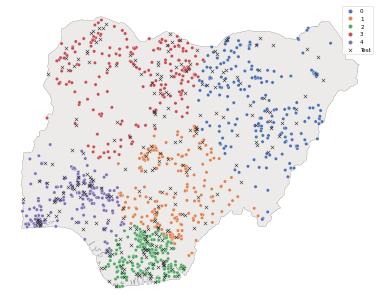

In [239]:
fig, ax = plt.subplots(figsize=(12, 10), dpi=400)

ax.grid(False)
plt.axis('off')
ax.set_facecolor('white')

plot_country(country_code, ax=ax)
sns.scatterplot(ax=ax, x="long", y="lat", hue="spatial_groups", data=X_train, palette='deep') #, hue_order=hue_order, kind="bar")
# sns.scatterplot(ax=ax, x="long", y="lat", data=X_test, color=".2", marker="x", label = 'Test', linewidth = 1) #, hue_order=hue_order, kind="bar")

# plt.title(country_code)

<AxesSubplot:xlabel='long', ylabel='lat'>

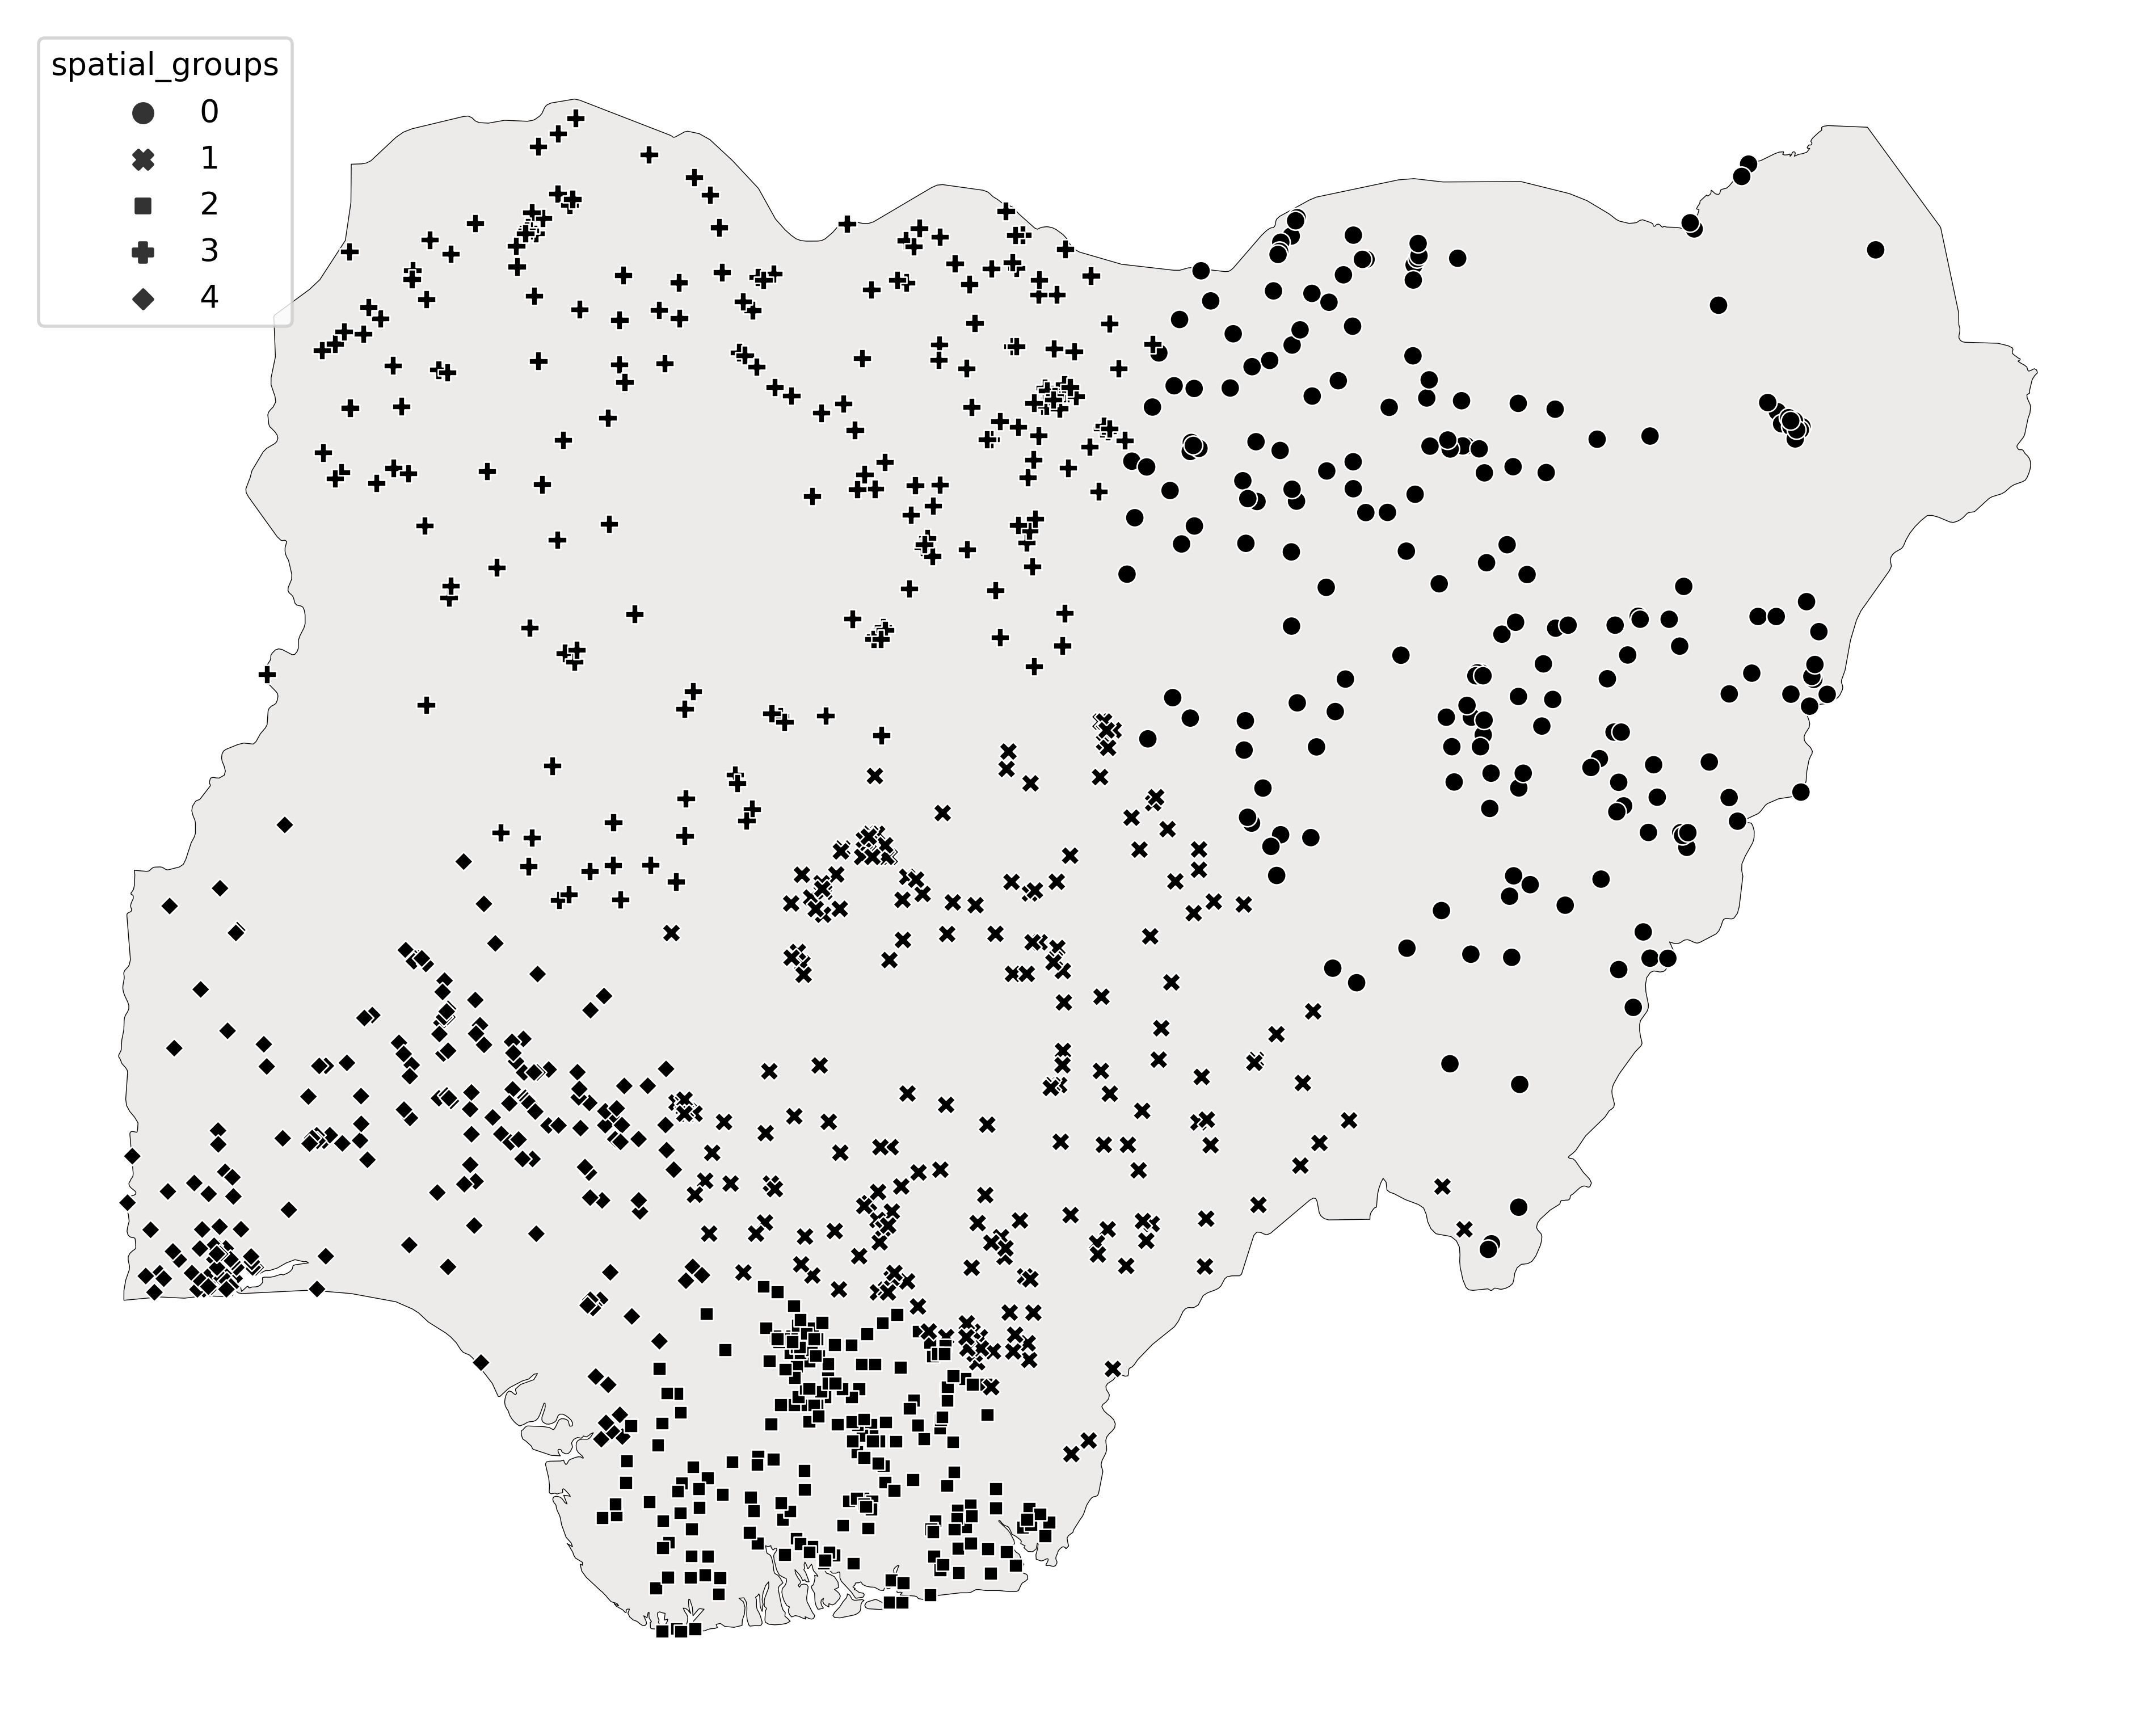

In [57]:
fig, ax = plt.subplots(figsize=(12, 10), dpi=400)

ax.grid(False)
plt.axis('off')
ax.set_facecolor('white')

sns.color_palette("gray", as_cmap=True)

plot_country(country_code, ax=ax)
sns.scatterplot(ax=ax, x="long", y="lat", style="spatial_groups", data=X_train, color='black') #, hue_order=hue_order, kind="bar")
# sns.scatterplot(ax=ax, x="long", y="lat", data=X_test, color=".2", marker="x", label = 'Test', linewidth = 1) #, hue_order=hue_order, kind="bar")

# plt.title(country_code)

# Results Experiment 1

In [10]:
country_code_dhs = list(hexes_dhs['country_code'].unique())
print(len(country_code_dhs))

25


In [12]:
res_exp1 = pd.read_csv(f'{read_path}/processed/exp1/20221114_exp1_results.csv')
print(res_exp1.shape)
res_exp1.head(2)

(25, 75)


,num_test,deprived_sev_mean_neigh_lgbm,BEN_lgbm,BFA_lgbm,BDI_lgbm,CMR_lgbm,COM_lgbm,COD_lgbm,GAB_lgbm,GIN_lgbm,KEN_lgbm,LSO_lgbm,LBR_lgbm,MWI_lgbm,MLI_lgbm,MOZ_lgbm,NAM_lgbm,NER_lgbm,NGA_lgbm,RWA_lgbm,SEN_lgbm,SLE_lgbm,TZA_lgbm,TGO_lgbm,UGA_lgbm,ZMB_lgbm,deprived_sev_mean_neigh_xgboost,2_or_more_prev_neigh_lgbm,2_or_more_prev_neigh_xgboost,3_or_more_prev_neigh_lgbm,3_or_more_prev_neigh_xgboost,4_or_more_prev_neigh_lgbm,4_or_more_prev_neigh_xgboost,housing_prev_neigh_lgbm,housing_prev_neigh_xgboost,water_prev_neigh_lgbm,water_prev_neigh_xgboost,sanitation_prev_neigh_lgbm,sanitation_prev_neigh_xgboost,sumpoor_prev_neigh_lgbm,sumpoor_prev_neigh_xgboost,country_code,AGO_lgbm,num_test_health,nutrition_prev_neigh_lgbm,nutrition_prev_neigh_xgboost,health_prev_neigh_lgbm,health_prev_neigh_xgboost,education_prev_neigh_lgbm,education_prev_neigh_xgboost,BEN_xgboost,BFA_xgboost,BDI_xgboost,CMR_xgboost,COM_xgboost,COD_xgboost,GAB_xgboost,GIN_xgboost,KEN_xgboost,LSO_xgboost,LBR_xgboost,MWI_xgboost,MLI_xgboost,MOZ_xgboost,NAM_xgboost,NER_xgboost,NGA_xgboost,RWA_xgboost,SEN_xgboost,SLE_xgboost,TZA_xgboost,TGO_xgboost,UGA_xgboost,ZMB_xgboost,AGO_xgboost
0,1193,0.636622,-0.581223,-0.275703,-0.019515,0.38867,-0.857874,-0.171607,0.366811,0.405279,-0.460131,-0.310817,0.047605,-2.616009,0.361722,0.121225,0.283215,-1.177947,0.267858,-0.113317,0.341283,0.153127,0.050041,-0.641459,-0.695116,0.260078,0.644066,0.778347,0.831355,0.715442,0.449906,0.336281,0.578088,0.244584,0.702118,0.588823,0.583424,0.851534,0.866139,0.704621,0.722360,AGO,0.636622,91,0.447113,0.317994,0.638032,0.634582,0.587194,0.508082,-0.451724,-0.100097,-0.021074,0.384673,-1.466087,-0.302960,0.382468,0.343780,-0.416552,-0.286742,-0.016887,-2.455027,0.352498,0.084861,0.318007,-1.196695,0.278963,-0.134583,0.366922,0.138835,0.053199,-0.384688,-0.624717,0.236647,0.644066
1,973,0.606495,0.606495,0.092570,-0.423850,0.05607,-0.883838,0.158332,0.092592,0.029253,0.078802,-1.259962,-0.102714,-4.834730,-0.224651,0.127716,-0.034410,0.096261,0.218974,-1.131021,-0.281527,-0.083711,-0.302898,0.248001,0.066310,-0.048580,0.514702,0.567612,0.640393,0.630755,0.656333,0.348884,0.446463,0.422894,0.652907,0.611475,0.513467,0.577113,0.547682,0.700066,0.743894,BEN,0.270418,283,0.747025,0.639304,0.712157,0.760051,0.644264,0.717136,0.514702,0.200143,-0.474894,0.034788,-0.794848,0.053411,0.211302,0.124318,0.119705,-0.570251,-0.047975,-3.878421,-0.079277,0.093774,-0.047061,-0.455789,0.161164,-1.181895,-0.155543,-0.021063,-0.207281,0.267338,0.180801,0.059802,0.324996


## R2 per country

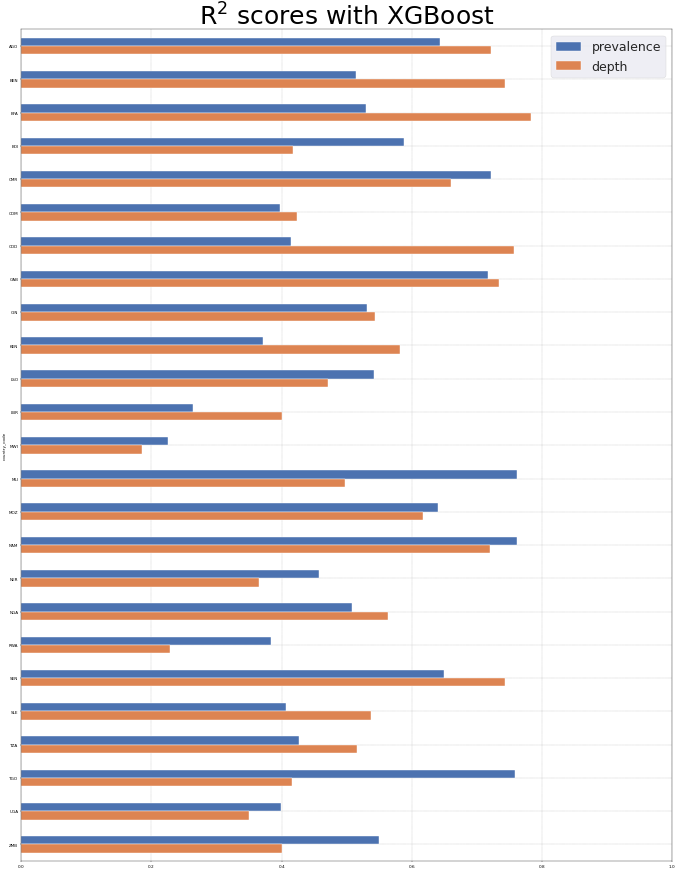

In [13]:
fig, ax = plt.subplots(figsize=(28,36), dpi=30) #dpi=300)
# fig, ax = plt.subplots(figsize=(10, 5))

sns.set(font_scale=5)

cols = ['country_code','prevalence', 'depth']
df = res_exp1[['country_code', 'deprived_sev_mean_neigh_xgboost', 'sumpoor_prev_neigh_xgboost']].rename(columns={'deprived_sev_mean_neigh_xgboost':'prevalence', 'sumpoor_prev_neigh_xgboost':'depth'})


df.plot(ax=ax,
        x='country_code',
        kind='barh',
        stacked=False,
        title='R$^2$ scores with XGBoost')

# ax.grid(True, color = "grey", linewidth = "1.4", linestyle = "-.")
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', linewidth = "0.5",)

plt.xlim((0,1))

ax.legend(loc='upper right', fontsize=30)

ax.invert_yaxis()

plt.show()

## Heatmap

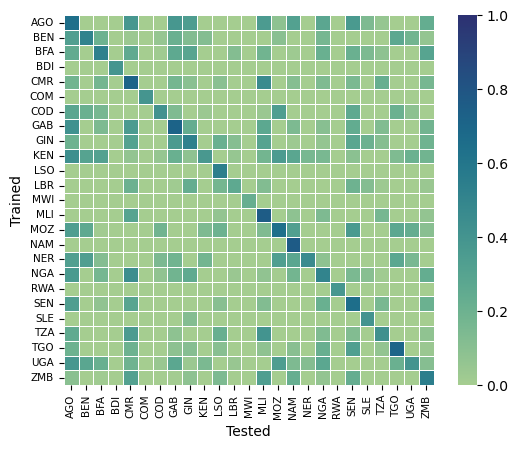

In [64]:
fig, ax = plt.subplots(dpi=100)

temp = [f'{cc}_xgboost' for cc in country_code_dhs]
dic_name_xgb = dict(zip(temp, country_code_dhs))
df = res_exp1.rename(columns=dic_name_xgb)

sns.heatmap(df[country_code_dhs], vmin=0, vmax=1, square=True, cmap="crest", linewidths=0.5)
ax.set(xlabel="Tested", ylabel="Trained")
_ = ax.set_xticklabels(res_exp1['country_code'], fontsize=7.5)
_ = ax.set_yticklabels(res_exp1['country_code'], fontsize=7.5)


## Average performance per prediction

In [53]:
res_exp1.loc['mean'] = res_exp1.mean(axis=0)

df = pd.DataFrame(res_exp1.loc['mean']).reset_index()
df.rename(columns= {'index':'dimension'}, inplace=True)

def select_type(x, mod):
    if bool(re.search(mod, x['dimension'])):
        return x['mean']
    else:
        return 0

df['lgbm'] = df.apply(lambda x: select_type(x, 'lgbm'), axis= 1)
df['xgboost'] = df.apply(lambda x: select_type(x, 'xgboost'), axis= 1)

df['dimension'] = df['dimension'].apply(lambda x: re.sub('_(mean|prev)_neigh_(lgbm|xgboost)', '', x))

df = df.groupby(['dimension'], as_index=False)['lgbm', 'xgboost'].sum()
df = df[df['lgbm']>0].copy()

ind_to_drop = [ind for ind in df.index if bool(re.search('(lgbm|xgboost)', df.loc[ind]['dimension']))]
df.drop(ind_to_drop, inplace=True)

In [54]:
df

,dimension,lgbm,xgboost
0,2_or_more,0.463401,0.500510
1,3_or_more,0.447340,0.485031
2,4_or_more,0.360676,0.529385
54,deprived_sev,0.527313,0.526564
55,education,0.538725,0.574332
56,health,0.421188,0.463621
57,housing,0.376789,0.474721
60,nutrition,0.430915,0.420934
61,sanitation,0.524940,0.548878
62,sumpoor,0.541634,0.535138


In [55]:
df['dimension'] = df['dimension'].replace(['sumpoor'], 'depth')
df['dimension'] = df['dimension'].replace(['deprived_sev'], 'prevalence')

df.sort_values(by='dimension', inplace=True)

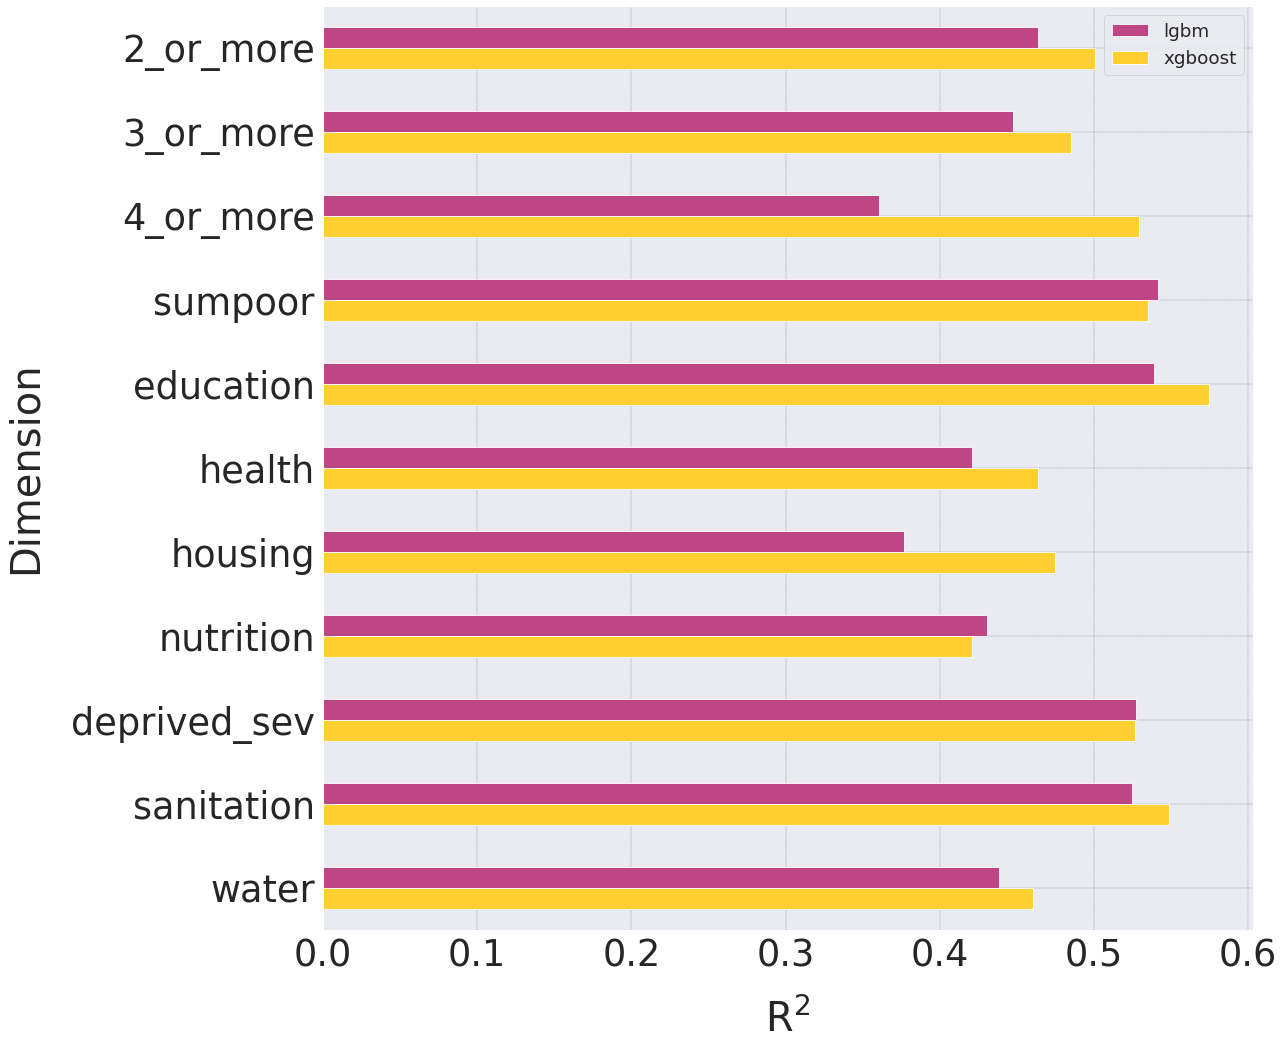

In [53]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=60)

sns.set(font_scale=4)
labelpad = 30

df.plot(ax=ax,
        x='dimension',
        kind='barh',
        stacked=False,
        color = ['#bf4684', '#ffce30'])
        # '#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0'

ax.legend(loc='upper right', fontsize=22)
plt.xlabel('R$^2$', labelpad = labelpad)
plt.ylabel('Dimension', labelpad = labelpad)

ax.invert_yaxis()
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', linewidth = "0.5",)



In [40]:
sns.color_palette("husl", 2)[1]

(0.21044753832183283, 0.6773105080456748, 0.6433941168468681)

## Average performance per prediction weighted

In [91]:
def weighted_mean(dim, col_w='num_test'):
    num_test = res_exp1[col_w].sum()
    if dim=='country_code':
        return 0
    else:
        tmp = res_exp1[dim] * res_exp1[col_w]
        tmp = tmp / num_test
        return tmp.sum()


In [92]:
df['dimension'] = df['dimension'].replace(['depth'], 'sumpoor')
df['dimension'] = df['dimension'].replace(['prevalence'], 'deprived_sev')

KeyError: 'dimension'

In [30]:
new_df = df[['dimension']].copy()

In [31]:
new_df = df[['dimension']].copy()

lgbm = []
xgboost = []
for dim in new_df['dimension']:
    if dim == 'deprived_sev':
        dim_name = 'deprived_sev_mean_neigh'
    else:
        dim_name = f'{dim}_prev_neigh'
    
    if (dim == 'nutrition') | (dim == 'health'):
        col_w = 'num_test_health'
    else:
        col_w = 'num_test'

    l = weighted_mean(f'{dim_name}_lgbm', col_w=col_w)
    x = weighted_mean(f'{dim_name}_xgboost', col_w=col_w)

    lgbm.append(l)
    xgboost.append(x)

new_df['lgbm'] = lgbm
new_df['xgboost'] = xgboost
new_df

,dimension,lgbm,xgboost
0,2_or_more,0.467522,0.496576
1,3_or_more,0.461916,0.465333
2,4_or_more,0.358713,0.545634
62,sumpoor,0.538743,0.537798
55,education,0.564544,0.581396
56,health,0.478244,0.557395
57,housing,0.380510,0.468859
60,nutrition,0.463054,0.510043
54,deprived_sev,0.506331,0.499386
61,sanitation,0.497621,0.517473


In [32]:
new_df['dimension'] = new_df['dimension'].replace(['sumpoor'], 'depth')
new_df['dimension'] = new_df['dimension'].replace(['deprived_sev'], 'prevalence')

new_df.sort_values(by='dimension', inplace=True)

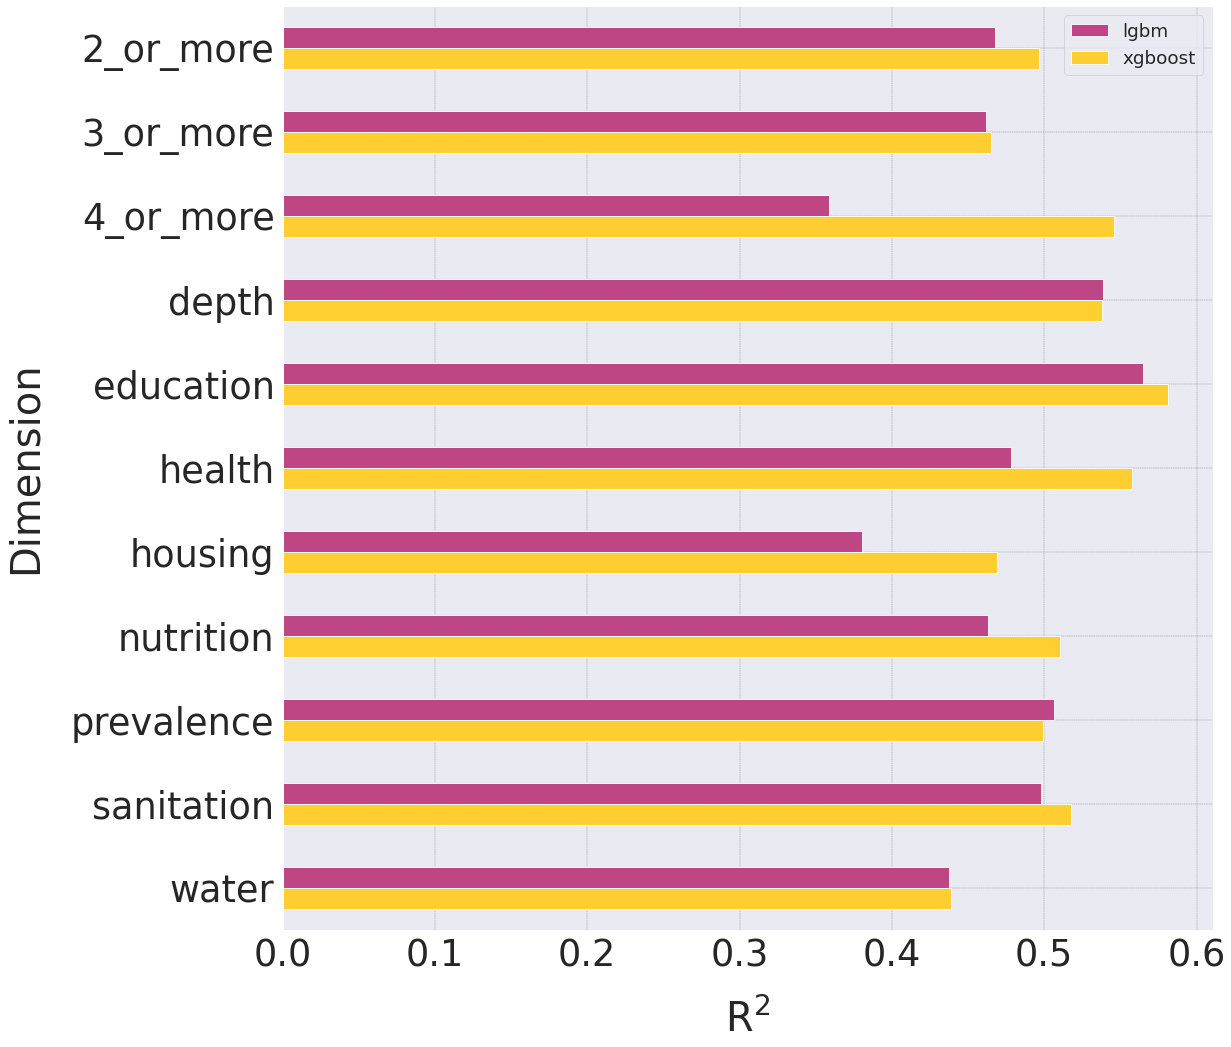

In [54]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=60)

sns.set(font_scale=4)
labelpad = 30

new_df.plot(ax=ax,
        x='dimension',
        kind='barh',
        stacked=False,
        color = ['#bf4684', '#ffce30'])

ax.legend(loc='upper right', fontsize=22)
plt.xlabel('R$^2$', labelpad = labelpad)
plt.ylabel('Dimension', labelpad = labelpad)

ax.invert_yaxis()
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', linewidth = "0.5",)

Rectangle(xy=(0, 10), width=0.46058, height=0.25, angle=0)
           //////////////////////


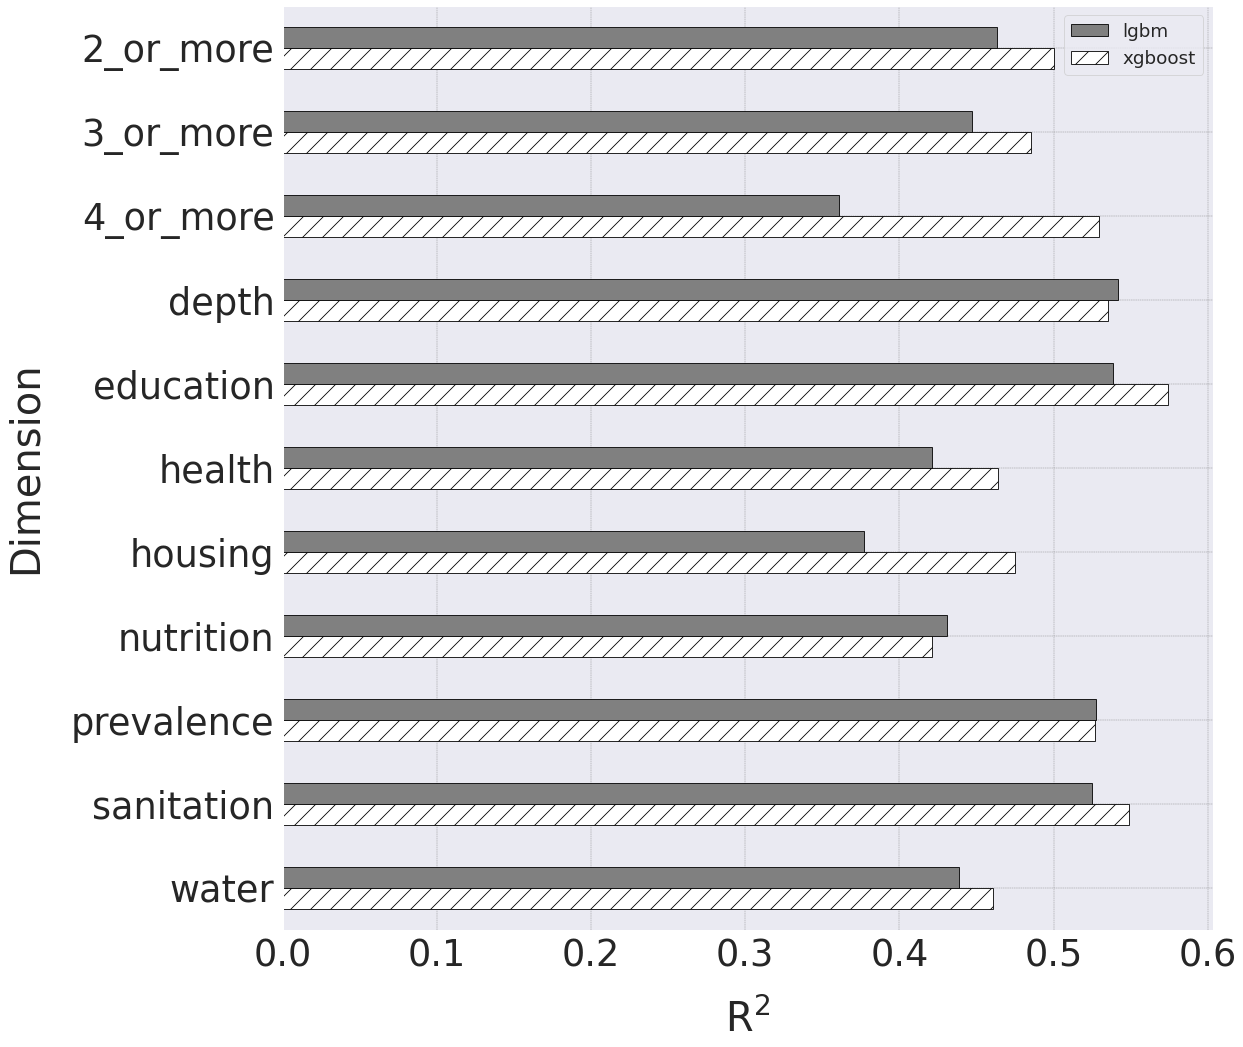

In [77]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=60)

sns.set(font_scale=4)
labelpad = 30

df.plot(ax=ax,
        x='dimension',
        kind='barh',
        stacked=False,
        edgecolor='black',
        color = ['gray', 'white'],
        legend=False)

bars = ax.patches
print(bar)
hatches = ''.join(h*len(df) for h in ' //')
print(hatches)
for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)


ax.legend(loc='upper right', fontsize=22)
plt.xlabel('R$^2$', labelpad = labelpad)
plt.ylabel('Dimension', labelpad = labelpad)

ax.invert_yaxis()
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', linewidth = "0.5",)

## table results xgboost

In [320]:
dimensions = ['country_code','deprived_sev_mean_neigh_xgboost', 
       '2_or_more_prev_neigh_xgboost',
       '3_or_more_prev_neigh_xgboost', 
       '4_or_more_prev_neigh_xgboost', 
       'sumpoor_prev_neigh_xgboost', 
       'housing_prev_neigh_xgboost', 
       'water_prev_neigh_xgboost', 
       'sanitation_prev_neigh_xgboost', 
       'nutrition_prev_neigh_xgboost',
       'health_prev_neigh_xgboost',
       'education_prev_neigh_xgboost'
       ]

dimensions_dic = {'deprived_sev_mean_neigh_xgboost':'prevalence', 
       '2_or_more_prev_neigh_xgboost':'2 or more',
       '3_or_more_prev_neigh_xgboost':'3 or more', 
       '4_or_more_prev_neigh_xgboost':'4 or more', 
       'sumpoor_prev_neigh_xgboost':'depth', 
       'housing_prev_neigh_xgboost':'housing', 
       'water_prev_neigh_xgboost':'water', 
       'sanitation_prev_neigh_xgboost':'sanitation',
       'nutrition_prev_neigh_xgboost':'nutrition',
       'health_prev_neigh_xgboost':'health',
       'education_prev_neigh_xgboost':'education'}

In [321]:
res_exp1 = res_exp1[dimensions]

res_exp1.rename(columns = dimensions_dic, inplace=True)
res_exp1_round = res_exp1.round(2)

In [56]:
# res_exp1_round.to_csv(read_path + '/processed/exp1_table_latex.csv', index=False)

## box plot

In [69]:
dimensions = ['country_code','deprived_sev_mean_neigh_xgboost', 
       '2_or_more_prev_neigh_xgboost',
       '3_or_more_prev_neigh_xgboost', 
       '4_or_more_prev_neigh_xgboost', 
       'sumpoor_prev_neigh_xgboost', 
       'housing_prev_neigh_xgboost', 
       'water_prev_neigh_xgboost', 
       'sanitation_prev_neigh_xgboost', 
       'nutrition_prev_neigh_xgboost',
       'health_prev_neigh_xgboost',
       'education_prev_neigh_xgboost'
       ]

dimensions_dic = {'deprived_sev_mean_neigh_xgboost':'prevalence', 
       '2_or_more_prev_neigh_xgboost':'2 or more',
       '3_or_more_prev_neigh_xgboost':'3 or more', 
       '4_or_more_prev_neigh_xgboost':'4 or more', 
       'sumpoor_prev_neigh_xgboost':'depth', 
       'housing_prev_neigh_xgboost':'housing', 
       'water_prev_neigh_xgboost':'water', 
       'sanitation_prev_neigh_xgboost':'sanitation',
       'nutrition_prev_neigh_xgboost':'nutrition',
       'health_prev_neigh_xgboost':'health',
       'education_prev_neigh_xgboost':'education'}
res_exp1 = res_exp1[dimensions]

res_exp1.rename(columns = dimensions_dic, inplace=True)


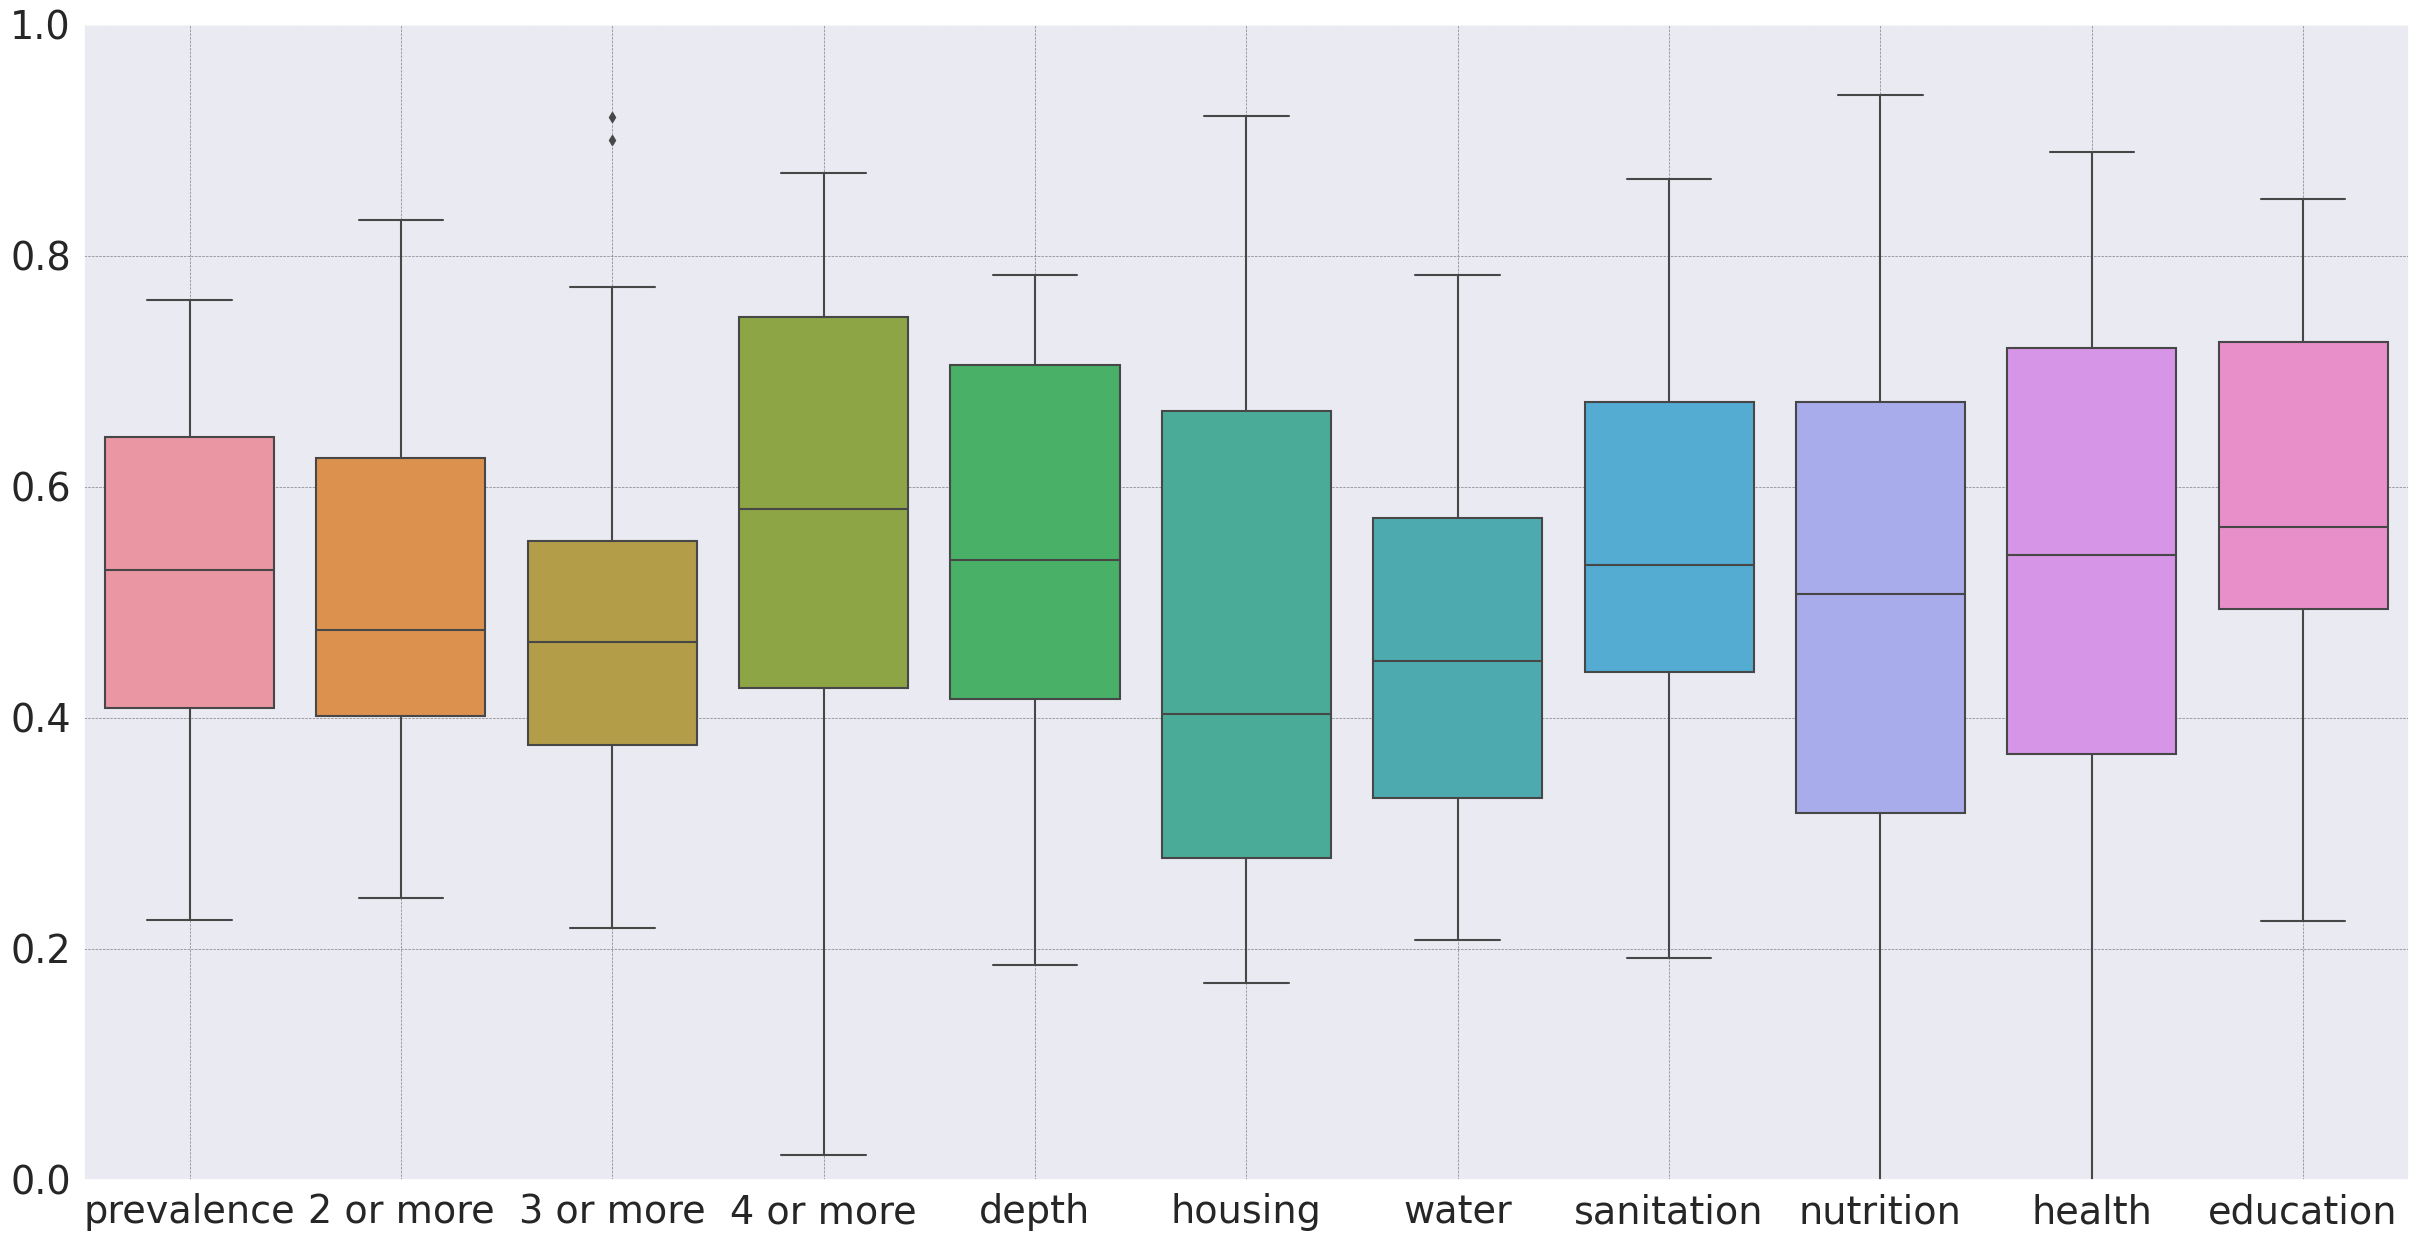

In [78]:
fig, ax = plt.subplots(figsize=(30, 15), dpi=100)

sns.set(font_scale=3)
sns.boxplot(res_exp1)

plt.ylim((0,1))

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', linewidth = "0.5",)


* num of missing value per input feature
* distribuzione delle features EDA